# CS4035 - Cyber Data Analytics
## Lab 2 - Anomaly Detection

### Submit on brightspace (zip file with the name Group_xx.zip)
(i) This jupyter file completed with code, plots, figures and report for each question. Additional plots and figures can be created for explanation before the end of each main question. Lab 2 contains 7 main questions, including the bonus. Write the code or explanation below each sub question. For the explantions, include what you would normally include in the report for this lab assignment, for example data pre-processing, hypothesis tested, approach, results, etc.
(ii) A PDF or a Word report for the assignment. Create a report from the plots, figures, tables and the write-up that you provide in this jupyter file. The report will be used as a proof for page limit. 
(iii) The libraries needed to run this file. 

Your peers should be able to use the readme section for instructions and be able to run this file. 

Maximum number of words is 1600, which you can count with the code below.

In [244]:
# If this cell does not work try running `pip install nbformat`


# import io
import nbformat

nb = nbformat.read("Lab2.ipynb", nbformat.NO_CONVERT)
word_count = 0
for cell in nb.cells:
    if cell.cell_type == "markdown":
        word_count += len(cell['source'].replace('#', '').lstrip().split(' '))

print("Word count:", word_count)

Word count: 1625


## Group Number : 1

## Student 1 
### Name : Amar Mesic
### ID : 5106117

### Individual parts: **PCA/ARMA**

## Student 2
### Name : Athanasios Georgoutsos
### ID : 6015883

### Individual parts: **LOF/N-Gram**

## Readme 

In [142]:
# Libraries used in this lab assignment
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import re
from scipy import signal
import json
import os

from sklearn.neighbors import LocalOutlierFactor
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.decomposition import PCA

import statsmodels.api as sm
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error

from collections import Counter
from sklearn.neighbors import NearestNeighbors
from sklearn.metrics.pairwise import cosine_distances

from sklearn.metrics import precision_recall_curve, auc, confusion_matrix, f1_score, accuracy_score, precision_score, recall_score

# The following code defines the paths of the data files
train_path = 'cda-lab-2-anomaly-detection/train_data.csv'
val_path = 'cda-lab-2-anomaly-detection/val_data.csv'
test_path = 'cda-lab-2-anomaly-detection/test_data.csv'

## 1. Familiarization task – 1 A4

In [3]:
# load data
train_data = pd.read_csv(train_path)
val_data = pd.read_csv(val_path)
test_data = pd.read_csv(test_path)

train_data.head()

Id               Timestamp    FIT101    LIT101  MV101  P101  P102  \
0   0   22/12/2015 4:00:00 PM  2.470294  261.5804      2     2     1   
1   1   22/12/2015 4:00:01 PM  2.457163  261.1879      2     2     1   
2   2   22/12/2015 4:00:02 PM  2.439548  260.9131      2     2     1   
3   3   22/12/2015 4:00:03 PM  2.428338  260.2850      2     2     1   
4   4   22/12/2015 4:00:04 PM  2.424815  259.8925      2     2     1   

     AIT201   AIT202   AIT203  ...  P501  P502    PIT501  PIT502    PIT503  \
0  244.3284  8.19008  306.101  ...     1     1  10.02948     0.0  4.277749   
1  244.3284  8.19008  306.101  ...     1     1  10.02948     0.0  4.277749   
2  244.3284  8.19008  306.101  ...     1     1  10.02948     0.0  4.277749   
3  244.3284  8.19008  306.101  ...     1     1  10.02948     0.0  4.277749   
4  244.4245  8.19008  306.101  ...     1     1  10.02948     0.0  4.277749   

     FIT601  P601  P602  P603  Label  
0  0.000256     1     1     1      0  
1  0.000256     1     1     1      0  
2  0.000256     1     1     1      0  
3  0.000256     1     1     1      0  
4  0.000256     1     1     1      0  

[5 rows x 54 columns]

In [4]:
# find out timestamp of first and last measurement
print('First measurement:', train_data['Timestamp'][0])
print('Last measurement:', train_data['Timestamp'][len(train_data)-1])

First measurement:  22/12/2015 4:00:00 PM
Last measurement:  28/12/2015 9:59:59 AM


In [5]:
# find out different columns
print('Columns:', train_data.columns)


Columns: Index(['Id', 'Timestamp', 'FIT101', 'LIT101', 'MV101', 'P101', 'P102',
       'AIT201', 'AIT202', 'AIT203', 'FIT201', 'MV201', 'P201', 'P202', 'P203',
       'P204', 'P205', 'P206', 'DPIT301', 'FIT301', 'LIT301', 'MV301', 'MV302',
       'MV303', 'MV304', 'P301', 'P302', 'AIT401', 'AIT402', 'FIT401',
       'LIT401', 'P401', 'P402', 'P403', 'P404', 'UV401', 'AIT501', 'AIT502',
       'AIT503', 'AIT504', 'FIT501', 'FIT502', 'FIT503', 'FIT504', 'P501',
       'P502', 'PIT501', 'PIT502', 'PIT503', 'FIT601', 'P601', 'P602', 'P603',
       'Label'],
      dtype='object')


In [6]:
# some preprocessing

# keep columns for signals
signals = train_data.columns.drop(['Id', 'Timestamp', 'Label'])
print('Number of signals:', len(signals))

# convert timestamp to datetime
train_data['Timestamp'] = pd.to_datetime(train_data['Timestamp'], dayfirst = True)

Number of signals: 51


C:\Users\Thanos\AppData\Local\Temp\ipykernel_4352\3409347687.py:8: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  train_data['Timestamp'] = pd.to_datetime(train_data['Timestamp'], dayfirst = True)


### 1a. Plot visualizations 

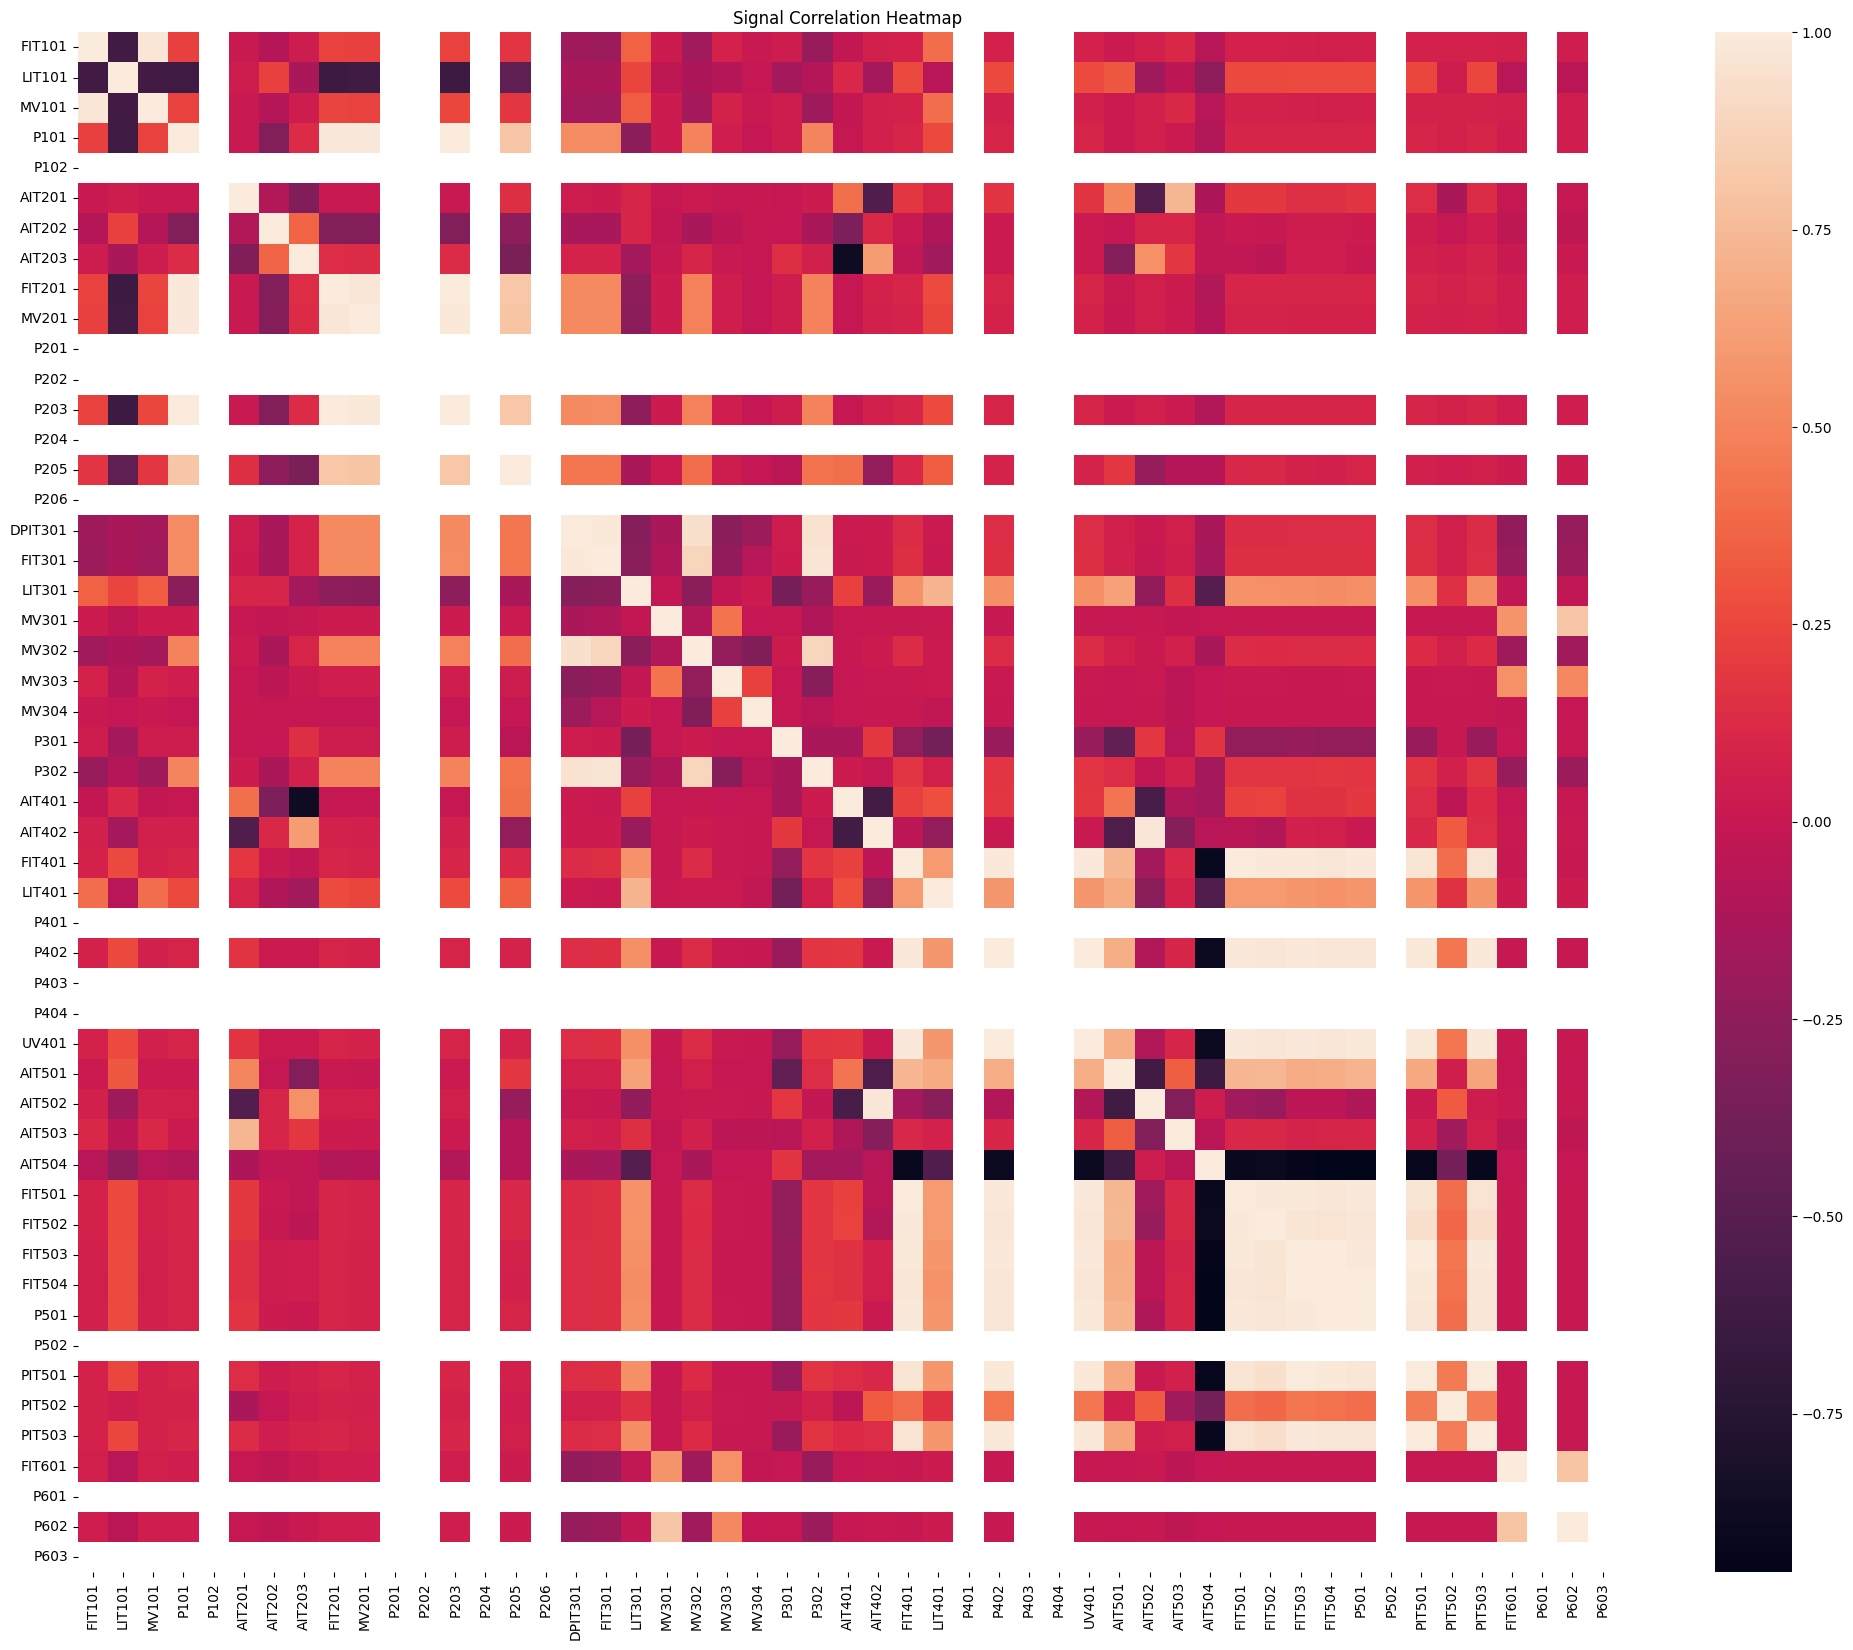

In [7]:
# plot heatmap to detect correlation
f, ax = plt.subplots(figsize =(25, 20))

train_signals = train_data[signals]

sns.heatmap(train_signals.corr(), square=True)
ax.set_title('Signal Correlation Heatmap')

plt.show()

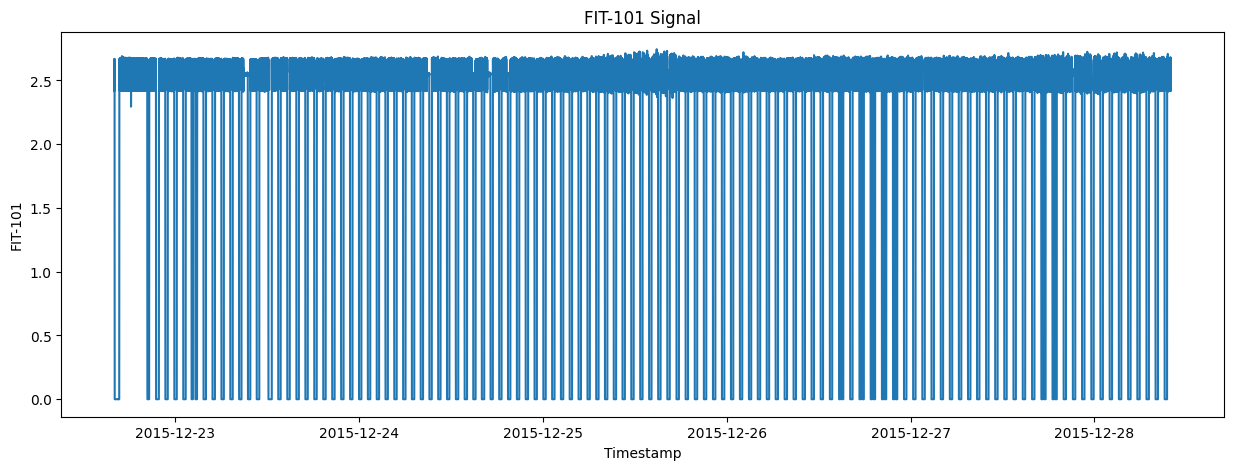

In [8]:
# plot sensor FIT-101
f, ax = plt.subplots(figsize =(15, 5))

fit101 = train_data['FIT101']

plt.plot(train_data['Timestamp'], fit101)
plt.xlabel('Timestamp')
plt.ylabel('FIT-101')
plt.title('FIT-101 Signal')

plt.show()

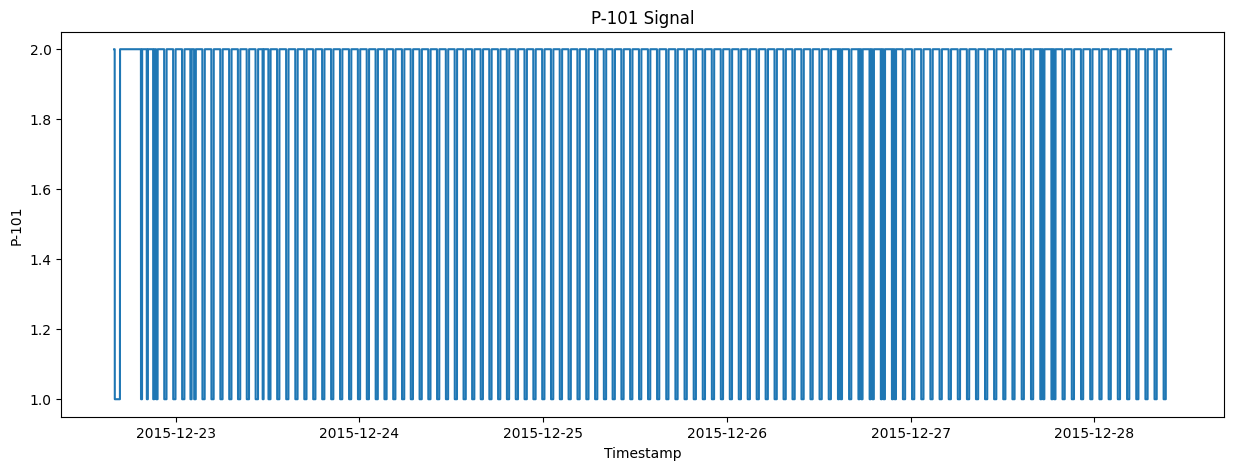

In [9]:
# plot sensor P-101
f, ax = plt.subplots(figsize =(15, 5))

p101 = train_data['P101']

plt.plot(train_data['Timestamp'], p101)
plt.xlabel('Timestamp')
plt.ylabel('P-101')
plt.title('P-101 Signal')

plt.show()

In [10]:
# for better visualization, we will focus on the second 24 hours of the data
start_time = train_data['Timestamp'][0] + pd.DateOffset(days=1)
end_time = start_time + pd.DateOffset(days=1)
print('Start time:', start_time)
print('End time:', end_time)

Start time: 2015-12-23 16:00:00
End time: 2015-12-24 16:00:00


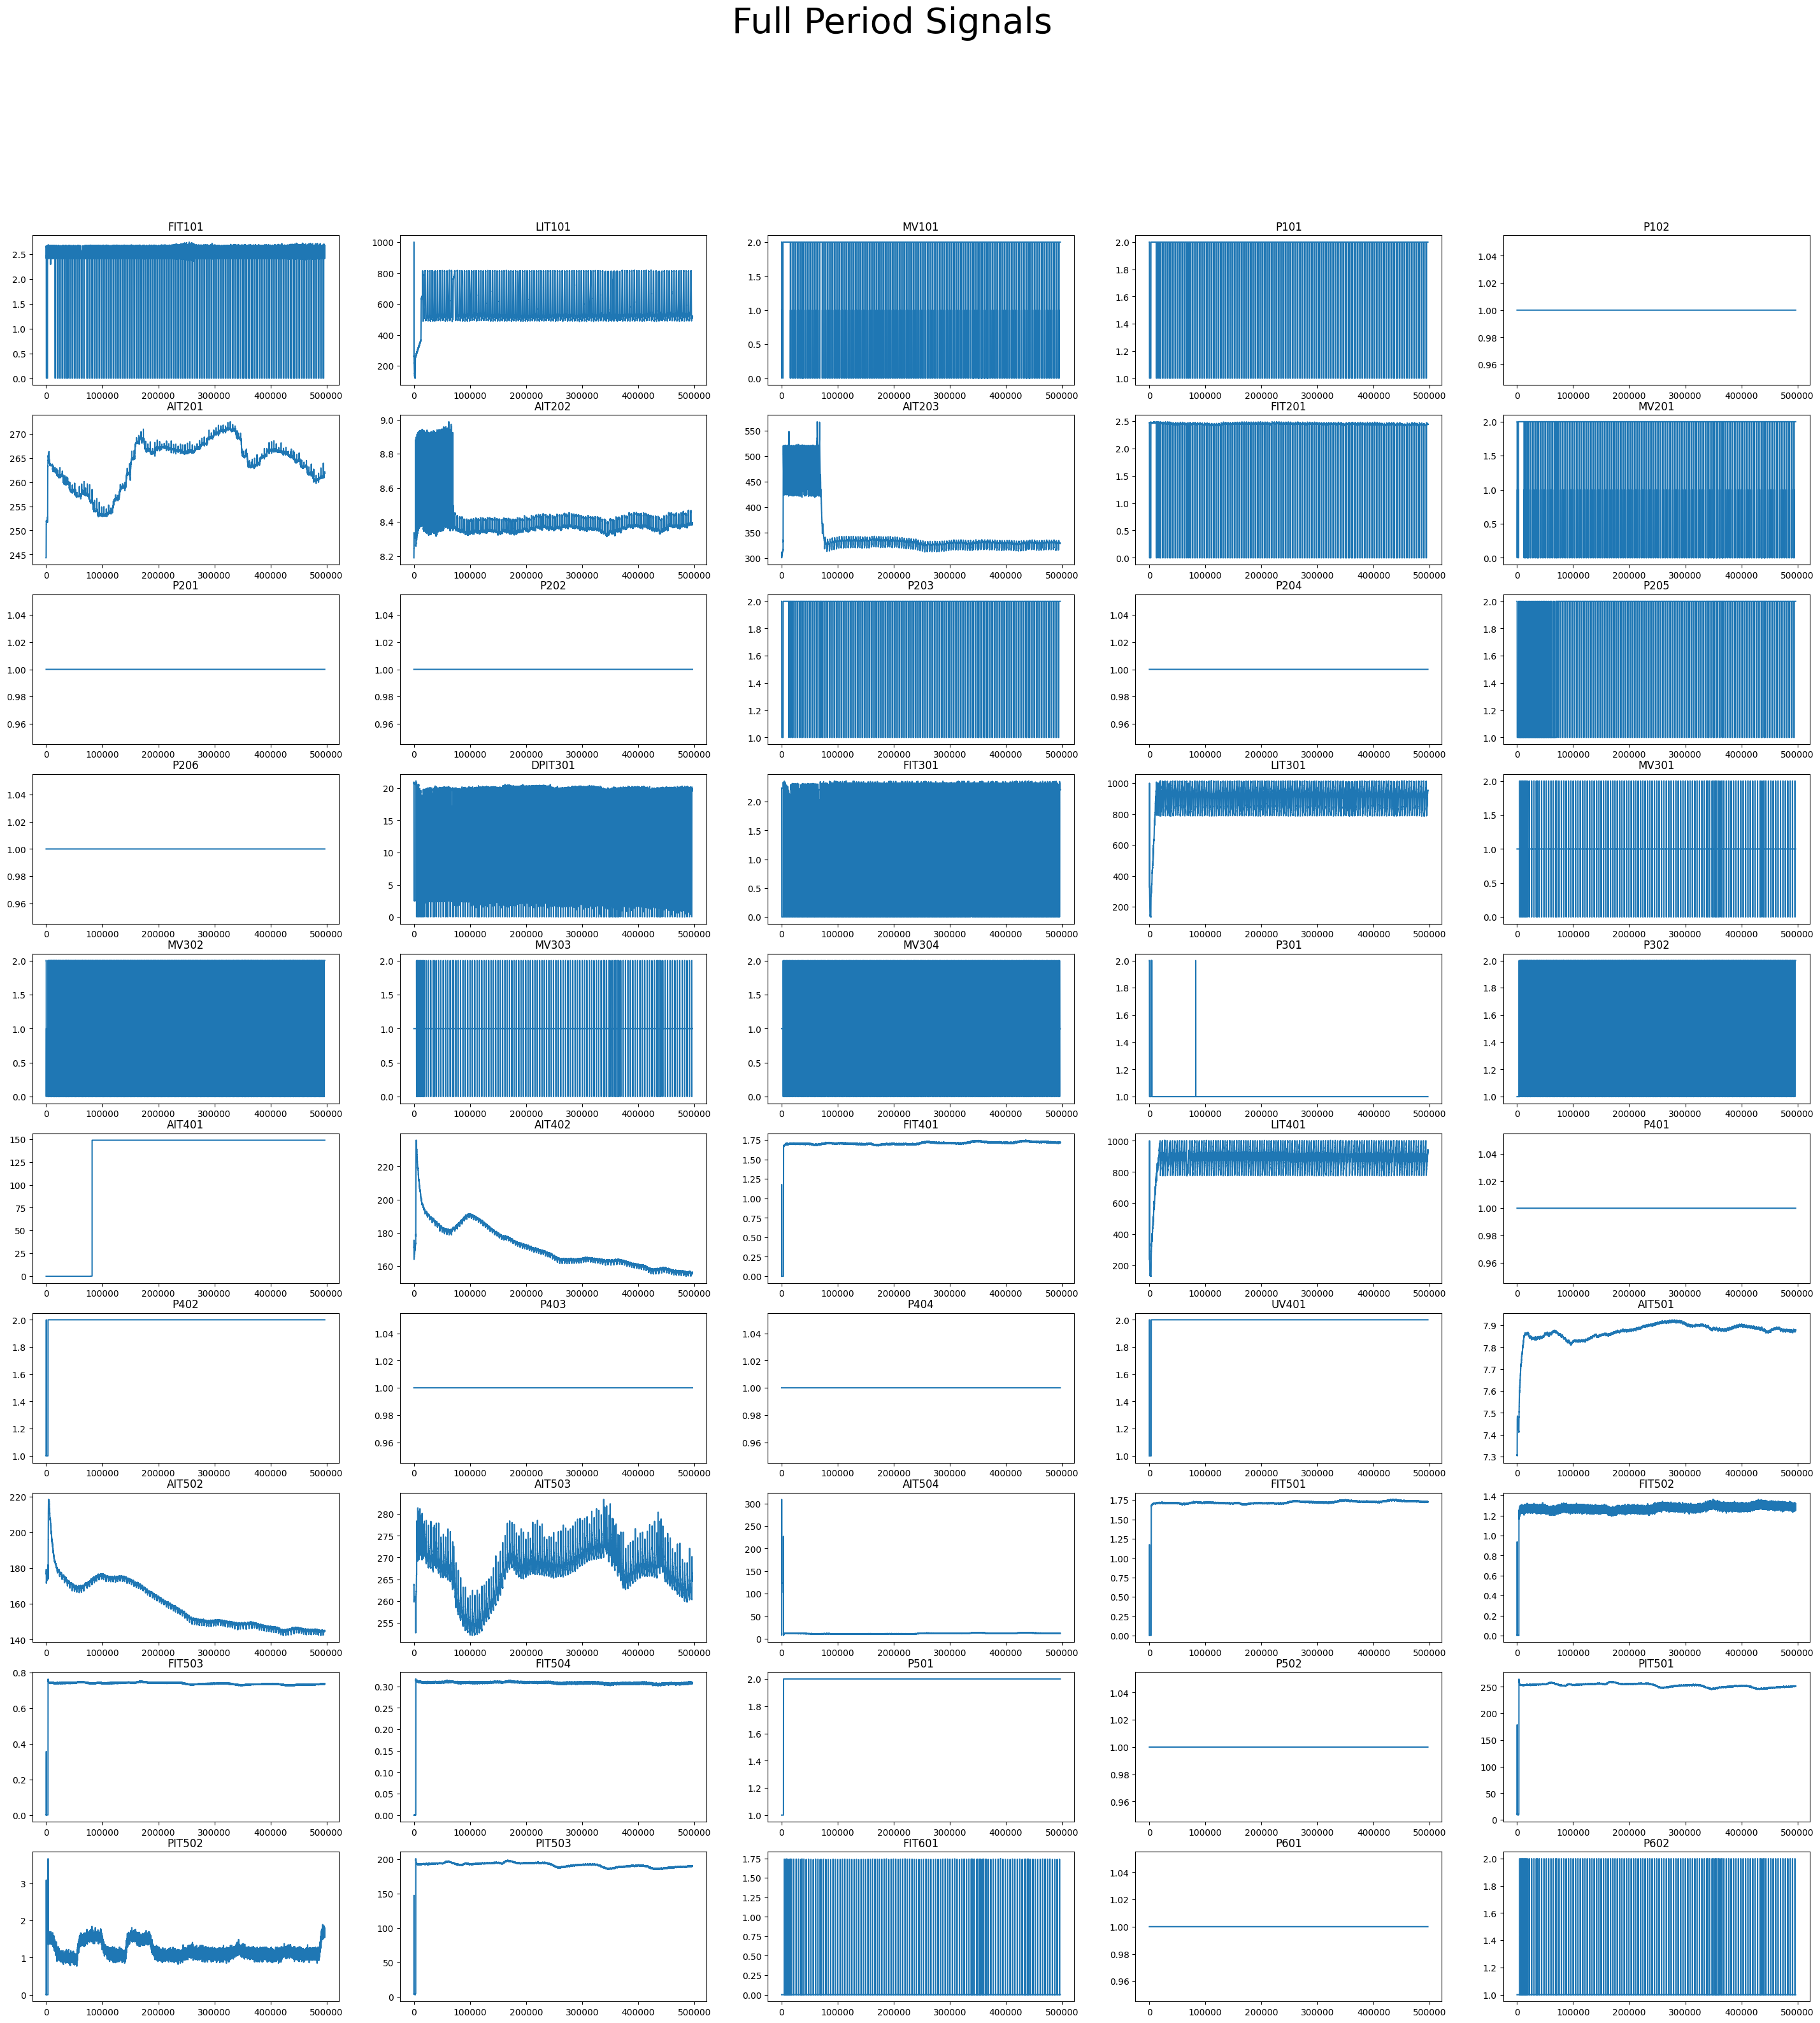

In [11]:
# Plot signals for the whole period
hor_plots = 5
ver_plots = 10
fig, axs = plt.subplots(ver_plots, hor_plots, figsize=(36, 36))
i, j = 0, 0

for row in range(ver_plots):
    for col in range(hor_plots):
        feature = signals[j]

        axs[row, col].plot(train_data[feature])
        axs[row, col].set_title(feature)
        j = j + 1

# set title 
fig.suptitle('Full Period Signals', fontsize=40)
plt.show()

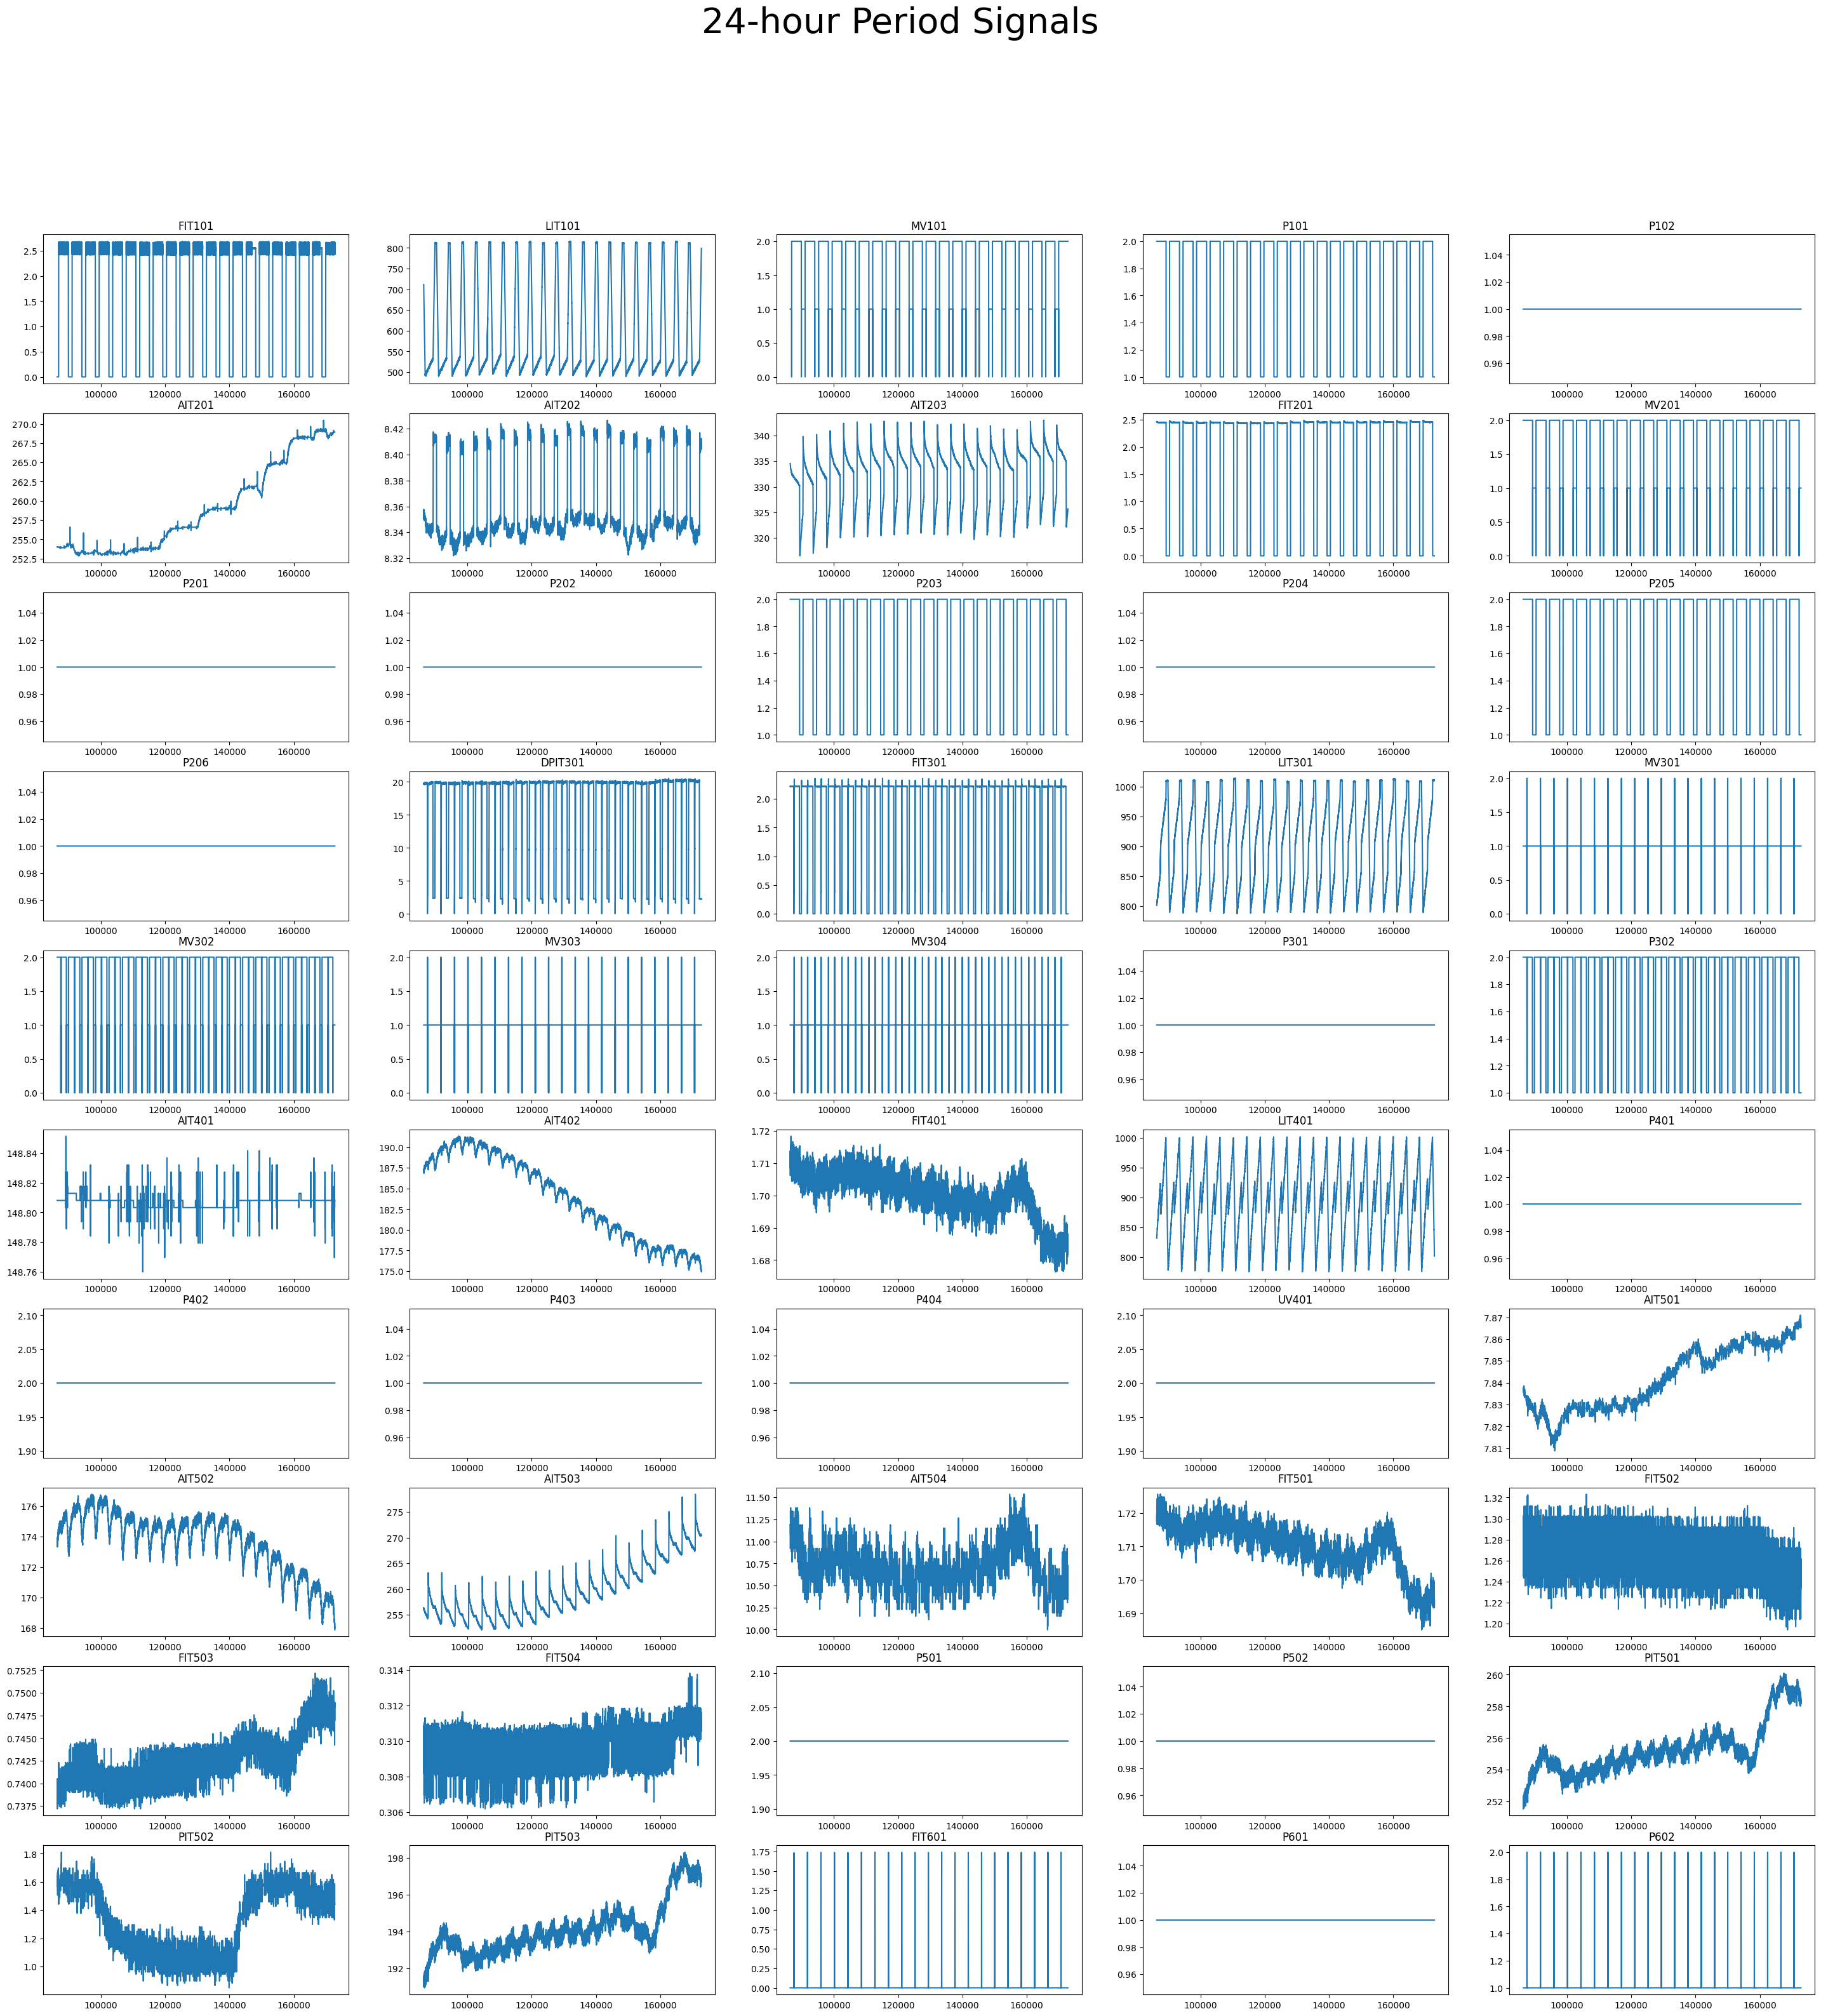

In [12]:
# Plotting signals for the second 24 hours
hor_plots = 5
ver_plots = 10
fig, axs = plt.subplots(ver_plots, hor_plots, figsize=(36, 36))
i, j = 0, 0

data_plot = train_data[(train_data['Timestamp'] >= start_time) & (train_data['Timestamp'] < end_time)]

for row in range(ver_plots):
    for col in range(hor_plots):
        feature = signals[j]

        axs[row, col].plot(data_plot[feature])
        axs[row, col].set_title(feature)
        j = j + 1

# set title 
fig.suptitle('24-hour Period Signals', fontsize=40)
plt.show()

### 1b. Answers to the three questions

#### Signal Types

In [90]:
# find sensors and actuators
# sensors: float values
# actuators: integer values

sensors = []
actuators = []

for signal in signals:
    if train_data[signal].dtype == 'float64':
        sensors.append(signal)
    elif train_data[signal].dtype == 'int64':
        actuators.append(signal)

print('Number of sensors:', len(sensors))
print(sensors)
print('Number of actuators:', len(actuators))
print(actuators)

Number of sensors: 25
['FIT101', 'LIT101', 'AIT201', 'AIT202', 'AIT203', 'FIT201', 'DPIT301', 'FIT301', 'LIT301', 'AIT401', 'AIT402', 'FIT401', 'LIT401', 'AIT501', 'AIT502', 'AIT503', 'AIT504', 'FIT501', 'FIT502', 'FIT503', 'FIT504', 'PIT501', 'PIT502', 'PIT503', 'FIT601']
Number of actuators: 26
['MV101', 'P101', 'P102', 'MV201', 'P201', 'P202', 'P203', 'P204', 'P205', 'P206', 'MV301', 'MV302', 'MV303', 'MV304', 'P301', 'P302', 'P401', 'P402', 'P403', 'P404', 'UV401', 'P501', 'P502', 'P601', 'P602', 'P603']


There are 51 signals in the train dataset and two types of signals, 25 sensors and 26 actuators. **Sensors** convert a physical parameter (i.e. LIT-101 for raw tank water level) to an electronic value. **Actuators** convert a signal into a physical output (i.e. P-101 for pumping water from raw water tank to second stage).

#### Correlation

Based on our signal correlation heatmap, we detect some strong positive and negative correlations among our data. Positive correlations can be spotted in cases where a signal serves as an input for another or the two signals are actuators that work together for an operation. For instance, actuator P-101, which pumps water from the raw water tank to the second stage showcases extreme positive correlation with sensor FIT-201, the flow transmitter. On the other hand, there are also some extremely negative correlations, mostly between the measurement of an object and signals that act against it. For instance, sensor AIT-504, the RO permeate conductivity analyzer that measures NaCl level, showcases extreme negative correlation with many signals, such as actuator P-501 that pumps dechlorinated water into the RO, thus reducing the levels of NaCl. Overall, we can identify many interesting correlations between the signals.

#### Cyclic Behavior

Based on our plots for the 2nd 24 hours of measurements, we can see that many signals show cyclic behavior. For instance, it is easy to validate, even just visually, that signals FIT-101, MV-101, FIT-201, LIT-301 et al., present cycles in this 24-hour window. Also, signals, like AIT-402 and AIT-503, show cyclic behavior, but because we don't have removed trends and seasonality elements from the time series, it is not completely clear. However, overall, most of the signals showcase cyclic behavior.

## 2. LOF task – 1/2 A4 – Individual

### 2a. Plot LOF scores

#### Preprocessing

In [123]:
# Preprocessing

# keep only signals - not sequential context
# separate sensors and actuators - 
# - else actuators are going to dominate the distance metric
lof_sensors = train_data[sensors]
lof_actuators = train_data[actuators]

# use MinMaxScaler on sensors
scaler = MinMaxScaler()
scaled_sensors = scaler.fit_transform(lof_sensors)
lof_sensors = pd.DataFrame(scaled_sensors, columns=lof_sensors.columns, index=lof_sensors.index)

# manually scale actuators
# we divide them by the total number of signals to regulate
# their impact on distance metrics
lof_actuators = lof_actuators / len(signals)

# combine sensors and actuators
lof_data = pd.concat([lof_sensors, lof_actuators], axis=1)


#### LOF with different numbers of neighbors

In [43]:
# NOTE: this cell is computationally expensive and requires over 30 minutes
# You can run this cell just with 5 neighbors to verify correctness.

# parameters to test with LOF
# default distance metric is Minkowski with p=2 -> Euclidean distance
n_neighbors = [5, 10, 20, 40, 100, 300]

# storing LOF scores for later usage
lof_neighbors_dict = {}
lof_neighbors_labels = {}

for n in n_neighbors:
    # Apply LOF
    lof = LocalOutlierFactor(n_neighbors=n)
    y_pred = lof.fit_predict(lof_data)
    lof_neighbors_labels[n] = y_pred
    
    lof_scores = -lof.negative_outlier_factor_
    lof_neighbors_dict[n] = lof_scores

    print("LOF scores for n_neighbors =", n, "are computed.")


LOF scores for n_neighbors = 300 are computed.


In [44]:
# NOTE: cell to store LOF scores in .json files
# no need to run this cell if you do not want to store LOF scores
# to store LOF scores in .json files, uncomment code below

# # make directory for lof files
# if not os.path.exists('lof_files'):
#     os.makedirs('lof_files')

# # store LOF scores in .json files
# for key in lof_neighbors_dict.keys():
#     with open('lof_files/lof_scores_' + str(key) + '.json', 'w') as f:
#         json.dump(lof_neighbors_dict[key].tolist(), f)

# # store LOF labels in .json files
# for key in lof_neighbors_labels.keys():
#     with open('lof_files/lof_labels_' + str(key) + '.json', 'w') as f:
#         json.dump(lof_neighbors_labels[key].tolist(), f)

In [195]:
# NOTE: code to load precomputed LOF scores and labels
# uncomment the following code to load LOF scores and labels

# n_neighbors = [5, 10, 20, 40, 100, 300]

# # load LOF scores from .json files
# lof_neighbors_dict = {}
# for n in n_neighbors:
#     with open('lof_files/lof_scores_' + str(n) + '.json', 'r') as f:
#         lof_neighbors_dict[n] = json.load(f)

# # load LOF labels from .json files
# lof_neighbors_labels = {}
# for n in n_neighbors:
#     with open('lof_files/lof_labels_' + str(n) + '.json', 'r') as f:
#         lof_neighbors_labels[n] = json.load(f)


C:\Users\Thanos\AppData\Local\Temp\ipykernel_9420\840945765.py:8: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  plt.scatter(np.arange(len(lof_neighbors_dict[n])), lof_neighbors_dict[n], c=colors, cmap='coolwarm', edgecolor='k', s=20)


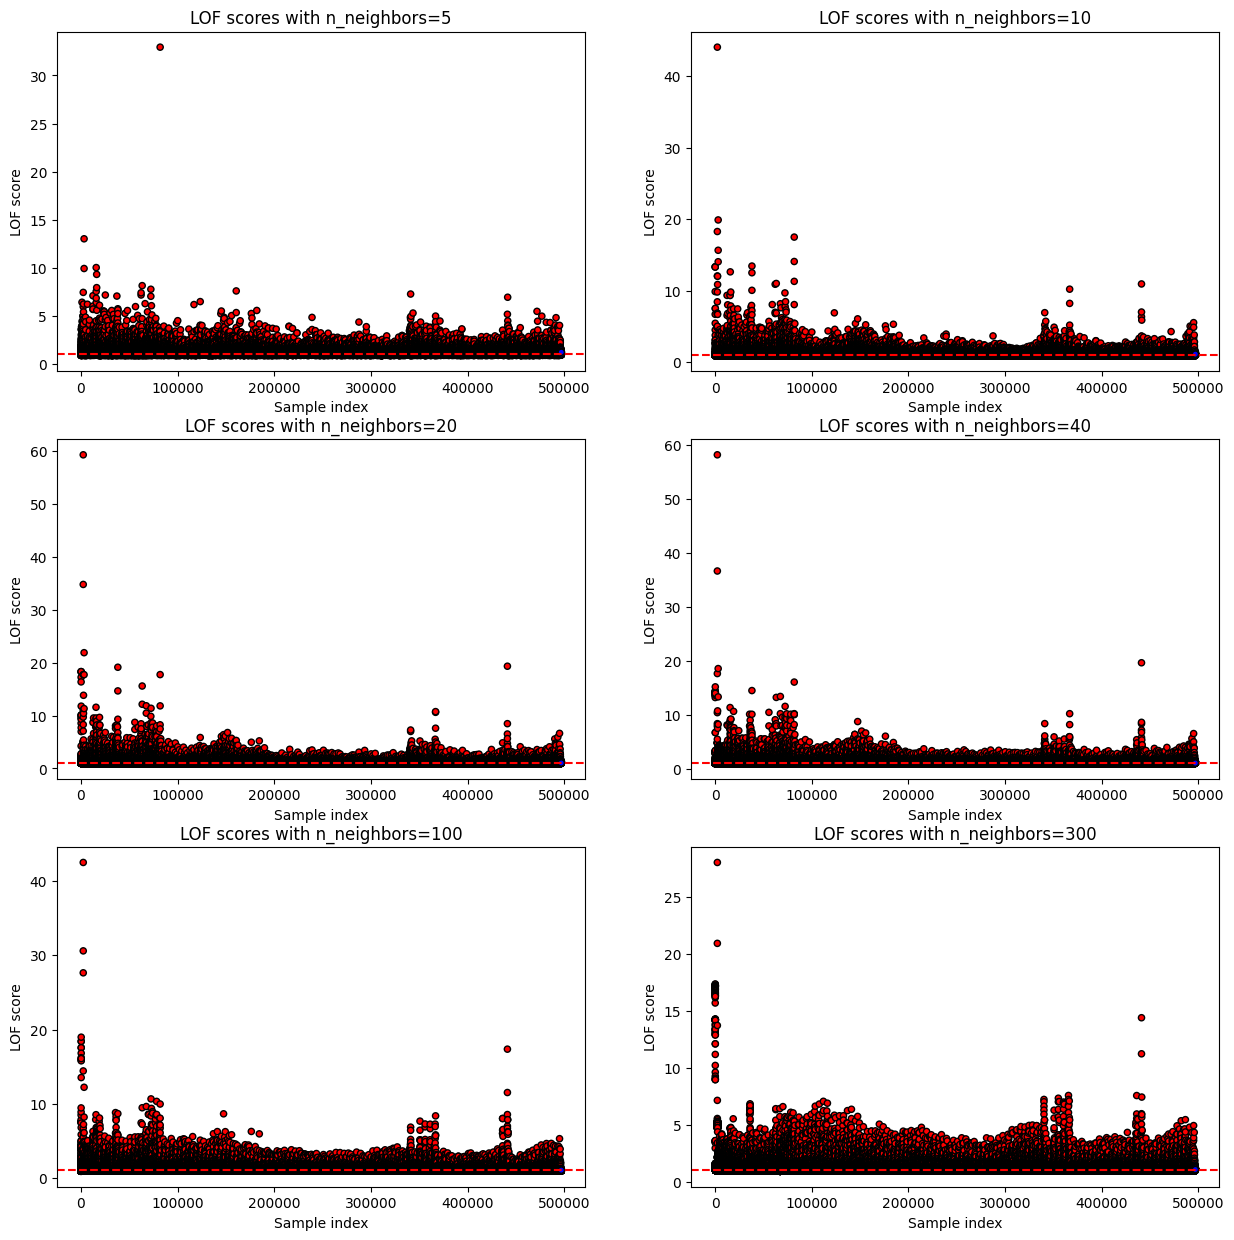

In [64]:
# plot LOF scores for different number of neighbors
plt.figure(figsize=(15, 15))

for i,n in enumerate(n_neighbors):
    plt.subplot(3, 2, i+1)
    colors = ['red' if label == -1 else 'blue' for label in lof_neighbors_labels[n]]

    plt.scatter(np.arange(len(lof_neighbors_dict[n])), lof_neighbors_dict[n], c=colors, cmap='coolwarm', edgecolor='k', s=20)
    plt.axhline(y=np.mean(lof_neighbors_dict[n]), color='r', linestyle='--')
    plt.title(f'LOF scores with n_neighbors={n}')
    plt.xlabel('Sample index')
    plt.ylabel('LOF score')


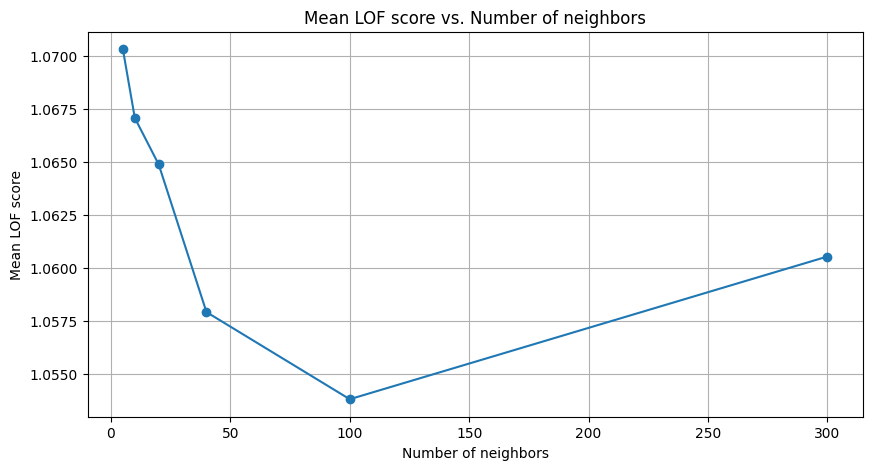

In [65]:
# Elbow rule to find the optimal number of neighbors
# plot mean LOF score against number of neighbors

mean_lof_scores = [np.mean(lof_neighbors_dict[n]) for n in n_neighbors]

plt.figure(figsize=(10, 5))
plt.plot(n_neighbors, mean_lof_scores, marker='o')
plt.title('Mean LOF score vs. Number of neighbors')
plt.xlabel('Number of neighbors')
plt.ylabel('Mean LOF score')
plt.grid()
plt.show()

#### LOF with different distance metrics

In [70]:
# NOTE: this cell is computationally expensive, and requires around 60 minutes
# You can run this cell just with euclidean metric to verify correctness.

# number of neighbors
n = 100
metrics = ['manhattan', 'euclidean', 'cosine']

# storing LOF scores for later usage
lof_metrics_dict = {}
lof_metrics_labels = {}

for m in metrics:
    # Apply LOF
    lof = LocalOutlierFactor(n_neighbors=n, metric=m)
    y_pred = lof.fit_predict(lof_data)
    lof_metrics_labels[m] = y_pred
    
    lof_scores = -lof.negative_outlier_factor_
    lof_metrics_dict[m] = lof_scores

    print("LOF scores for metric =", m, "are computed.")


LOF scores for metric = manhattan are computed.
LOF scores for metric = euclidean are computed.


In [71]:
# NOTE: cell to store LOF scores in .json files
# no need to run this cell if you do not want to store LOF scores
# to store LOF scores in .json files, uncomment code below

# # make directory for lof files
# if not os.path.exists('lof_files'):
#     os.makedirs('lof_files')

# # store LOF scores in .json files
# for key in lof_metrics_dict.keys():
#     with open('lof_files/lof_scores_' + key + '.json', 'w') as f:
#         json.dump(lof_metrics_dict[key].tolist(), f)

# # store LOF labels in .json files
# for key in lof_metrics_labels.keys():
#     with open('lof_files/lof_labels_' + key + '.json', 'w') as f:
#         json.dump(lof_metrics_labels[key].tolist(), f)

In [15]:
# NOTE: code to load precomputed LOF scores and labels
# uncomment the following code to load LOF scores and labels

# metrics = ['manhattan', 'euclidean', 'cosine']

# # load LOF scores from .json files
# lof_metrics_dict = {}
# for m in metrics:
#     with open('lof_files/lof_scores_' + m + '.json', 'r') as f:
#         lof_metrics_dict[m] = json.load(f)

# # load LOF labels from .json files
# lof_metrics_labels = {}
# for m in metrics:
#     with open('lof_files/lof_labels_' + m + '.json', 'r') as f:
#         lof_metrics_labels[m] = json.load(f)

C:\Users\Thanos\AppData\Local\Temp\ipykernel_7492\2472672483.py:8: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  plt.scatter(np.arange(len(lof_metrics_dict[m])), lof_metrics_dict[m], c=colors, cmap='coolwarm', edgecolor='k', s=20)


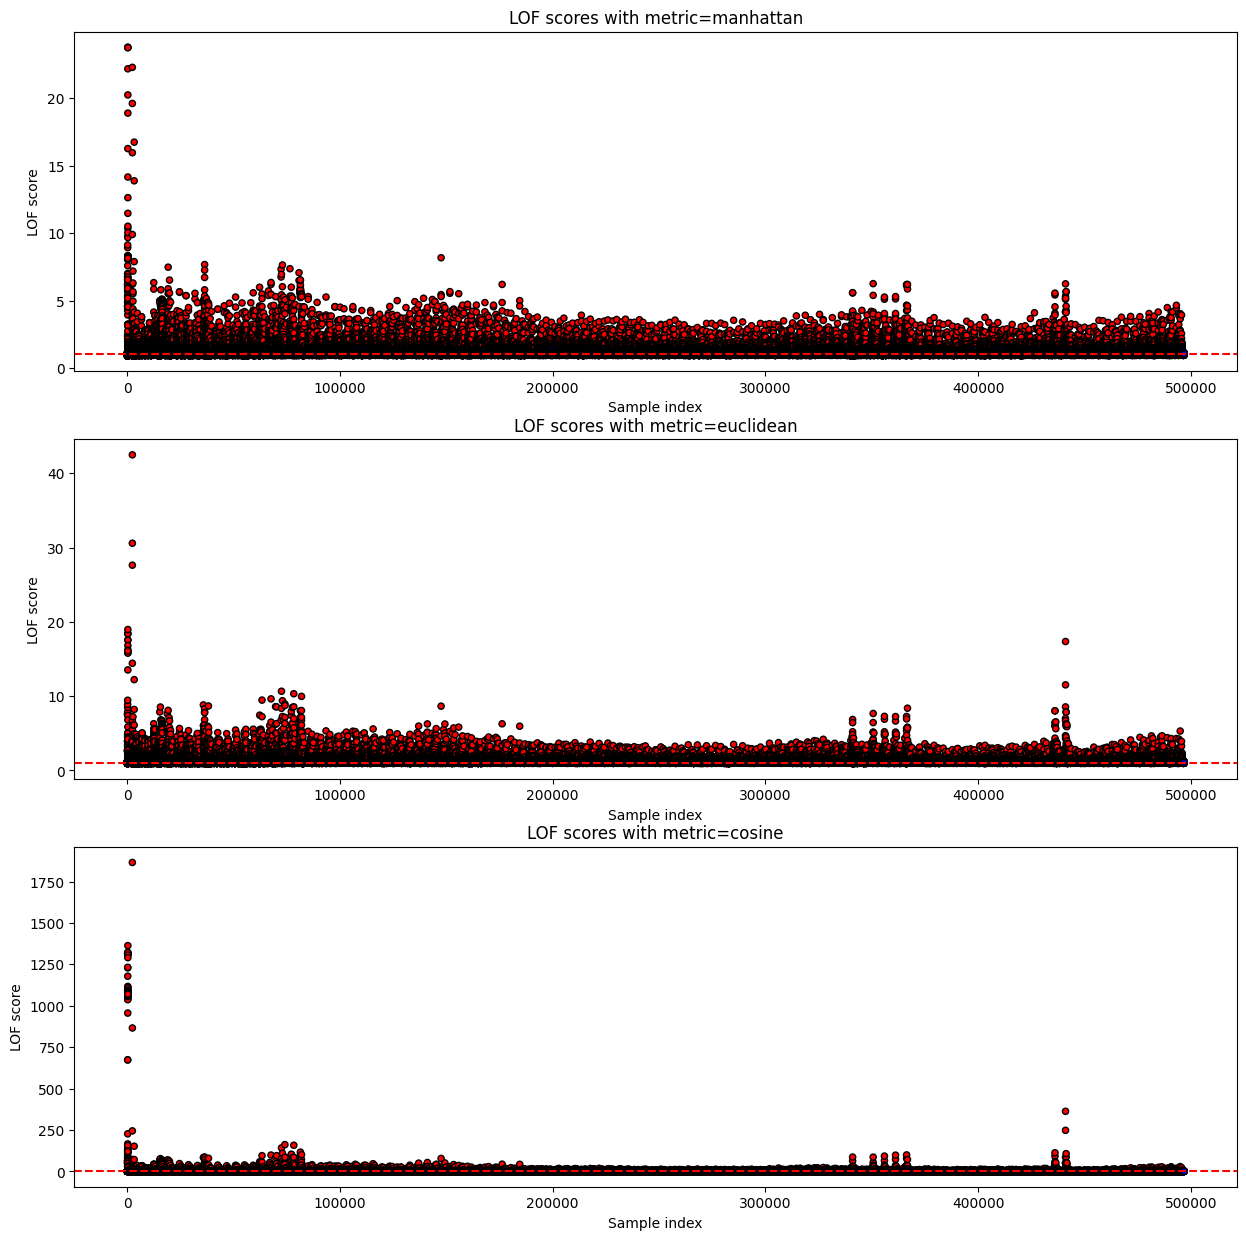

In [16]:
# plot LOF scores for different number of neighbors
plt.figure(figsize=(15, 15))

for i,m in enumerate(metrics):
    plt.subplot(3, 1, i+1)
    colors = ['red' if label == -1 else 'blue' for label in lof_metrics_labels[m]]

    plt.scatter(np.arange(len(lof_metrics_dict[m])), lof_metrics_dict[m], c=colors, cmap='coolwarm', edgecolor='k', s=20)
    plt.axhline(y=np.mean(lof_metrics_dict[m]), color='r', linestyle='--')
    plt.title(f'LOF scores with metric={m}')
    plt.xlabel('Sample index')
    plt.ylabel('LOF score')

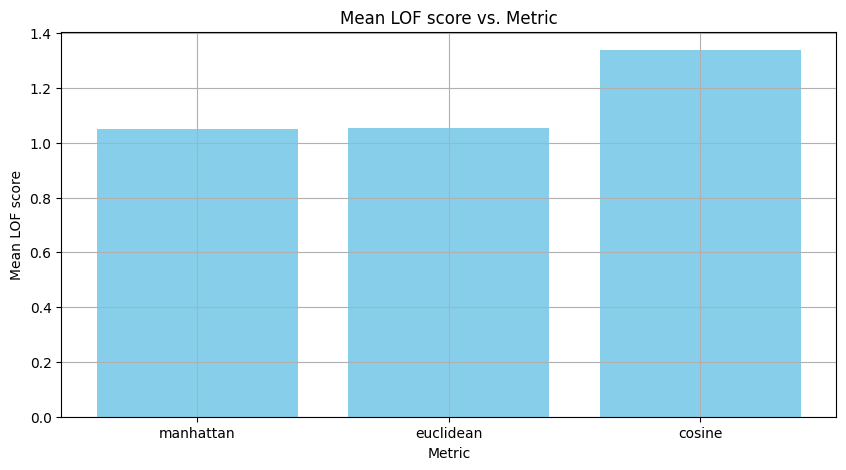

In [17]:
# bar plot with mean LOF scores for different metrics

mean_lof_scores = [np.mean(lof_metrics_dict[m]) for m in metrics]

plt.figure(figsize=(10, 5))
plt.bar(metrics, mean_lof_scores, color='skyblue')
plt.title('Mean LOF score vs. Metric')
plt.xlabel('Metric')
plt.ylabel('Mean LOF score')
plt.grid()
plt.show()

#### Final Choice

In [ ]:
# NOTE: running this cell takes approximately 18 minutes
# neighbors and metric
n = 100
m = 'manhattan'

# Apply LOF
lof = LocalOutlierFactor(n_neighbors=n, metric=m)
final_lof_labels = lof.fit_predict(lof_data)
final_lof_scores = -lof.negative_outlier_factor_

In [124]:
# NOTE: code to load precomputed LOF scores and labels
# uncomment the following code to load LOF scores and labels

# # load LOF scores from .json files
# with open('lof_files/lof_scores_' + 'manhattan' + '.json', 'r') as f:
#     final_lof_scores = json.load(f)

# # load LOF labels from .json files
# with open('lof_files/lof_labels_' + 'manhattan' + '.json', 'r') as f:
#     final_lof_labels = json.load(f)

C:\Users\Thanos\AppData\Local\Temp\ipykernel_4352\3599116219.py:3: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  plt.scatter(np.arange(len(final_lof_scores)), final_lof_scores, c=colors, cmap='coolwarm', edgecolor='k', s=20)


Text(0, 0.5, 'LOF score')

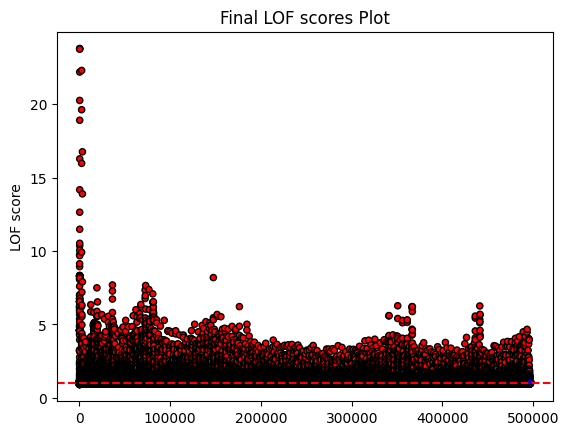

In [125]:
colors = ['red' if label == -1 else 'blue' for label in final_lof_labels]

plt.scatter(np.arange(len(final_lof_scores)), final_lof_scores, c=colors, cmap='coolwarm', edgecolor='k', s=20)
plt.axhline(y=np.mean(final_lof_scores), color='r', linestyle='--')
plt.title(f'Final LOF scores Plot')
plt.ylabel('LOF score')

### 2b. Analysis and answers to the questions

In [126]:
lof_data = pd.concat([train_data['Timestamp'], lof_data], axis=1)
lof_data = pd.concat([lof_data, pd.DataFrame(final_lof_scores, columns=['LOF Score'])], axis=1)
lof_data = pd.concat([lof_data, pd.DataFrame(final_lof_labels, columns=['LOF Label'])], axis=1)

# Separate outliers and inliers
lof_outliers = lof_data[lof_data['LOF Label'] == -1]
print('Number of outliers:', len(lof_outliers))

lof_inliers = lof_data[lof_data['LOF Label'] == 1]
print('Number of inliers:', len(lof_inliers))

Number of outliers: 10427
Number of inliers: 486373


In [45]:
# check median timestamp of LOF scores for outliers and inliers
print('Median timestamp for outliers:', lof_outliers['Timestamp'].median())
print('Median timestamp for inliers:', lof_inliers['Timestamp'].median())

Median timestamp for outliers: 2015-12-24 09:28:45
Median timestamp for inliers: 2015-12-25 13:26:25


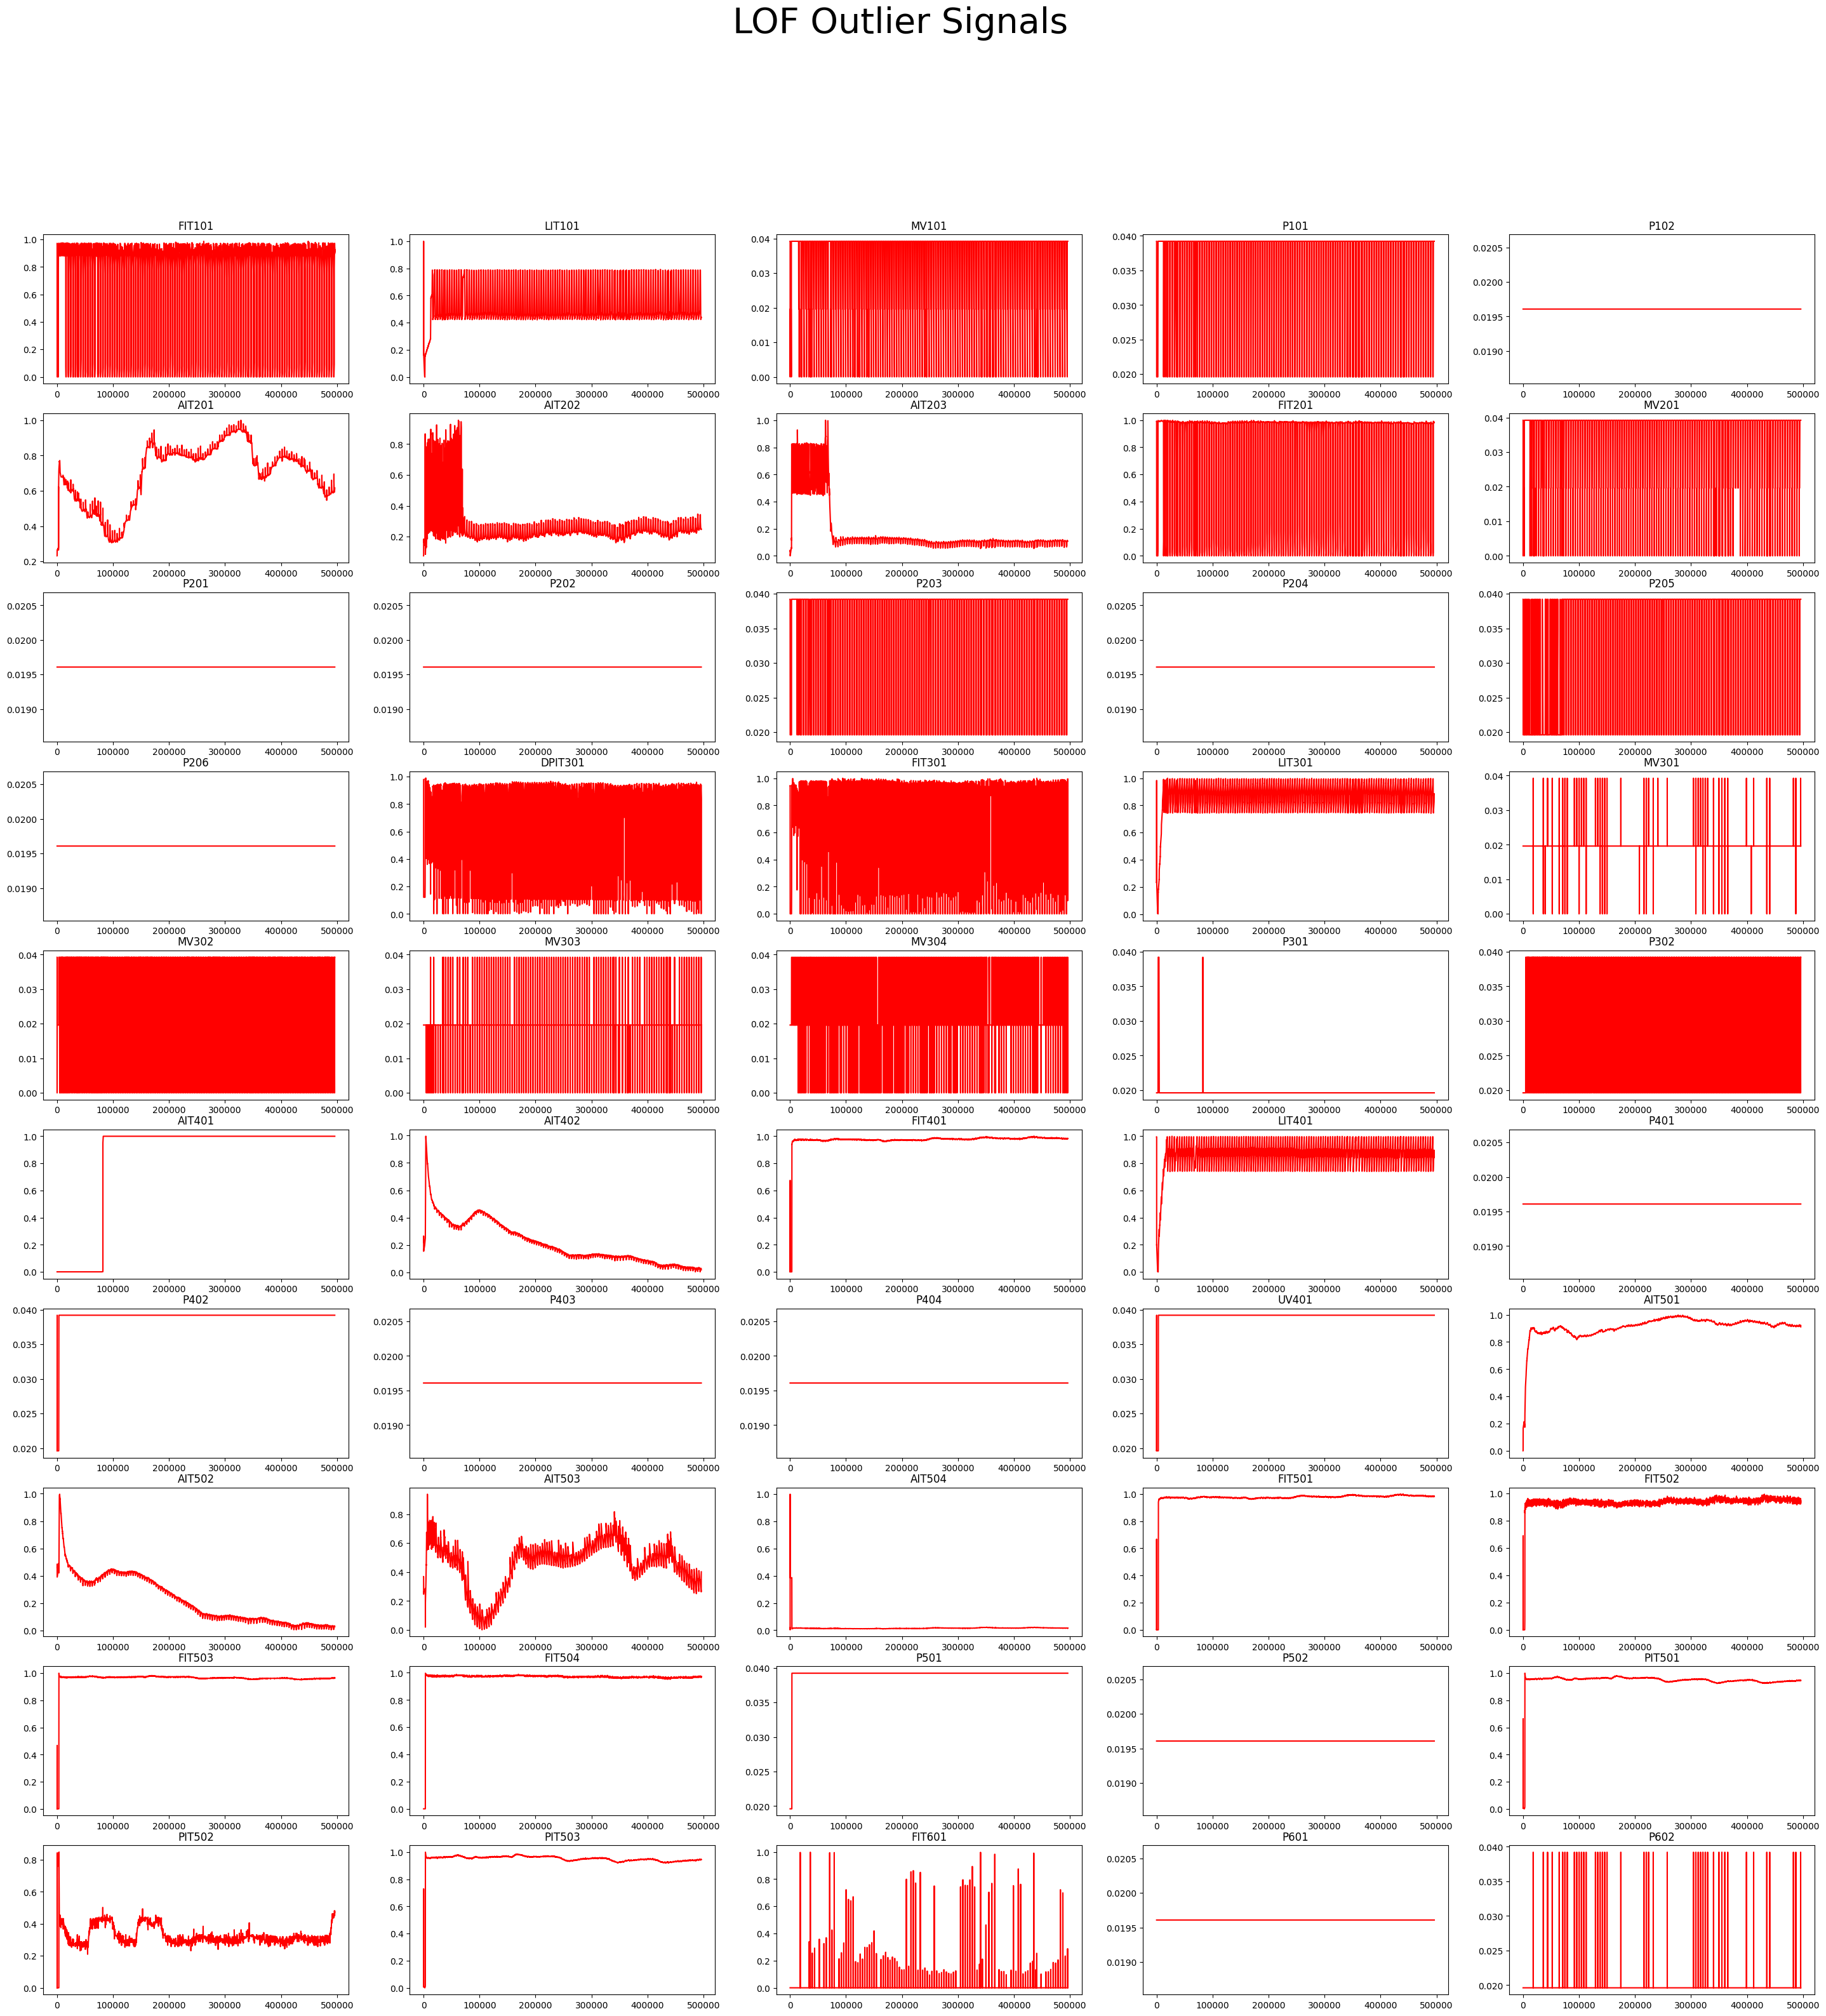

In [46]:
# Plot outliers for the whole period
hor_plots = 5
ver_plots = 10
fig, axs = plt.subplots(ver_plots, hor_plots, figsize=(36, 36))
i, j = 0, 0

for row in range(ver_plots):
    for col in range(hor_plots):
        feature = signals[j]

        axs[row, col].plot(lof_outliers[feature], color='red')
        axs[row, col].set_title(feature)
        j = j + 1

# set title 
fig.suptitle('LOF Outlier Signals', fontsize=40)
plt.show()

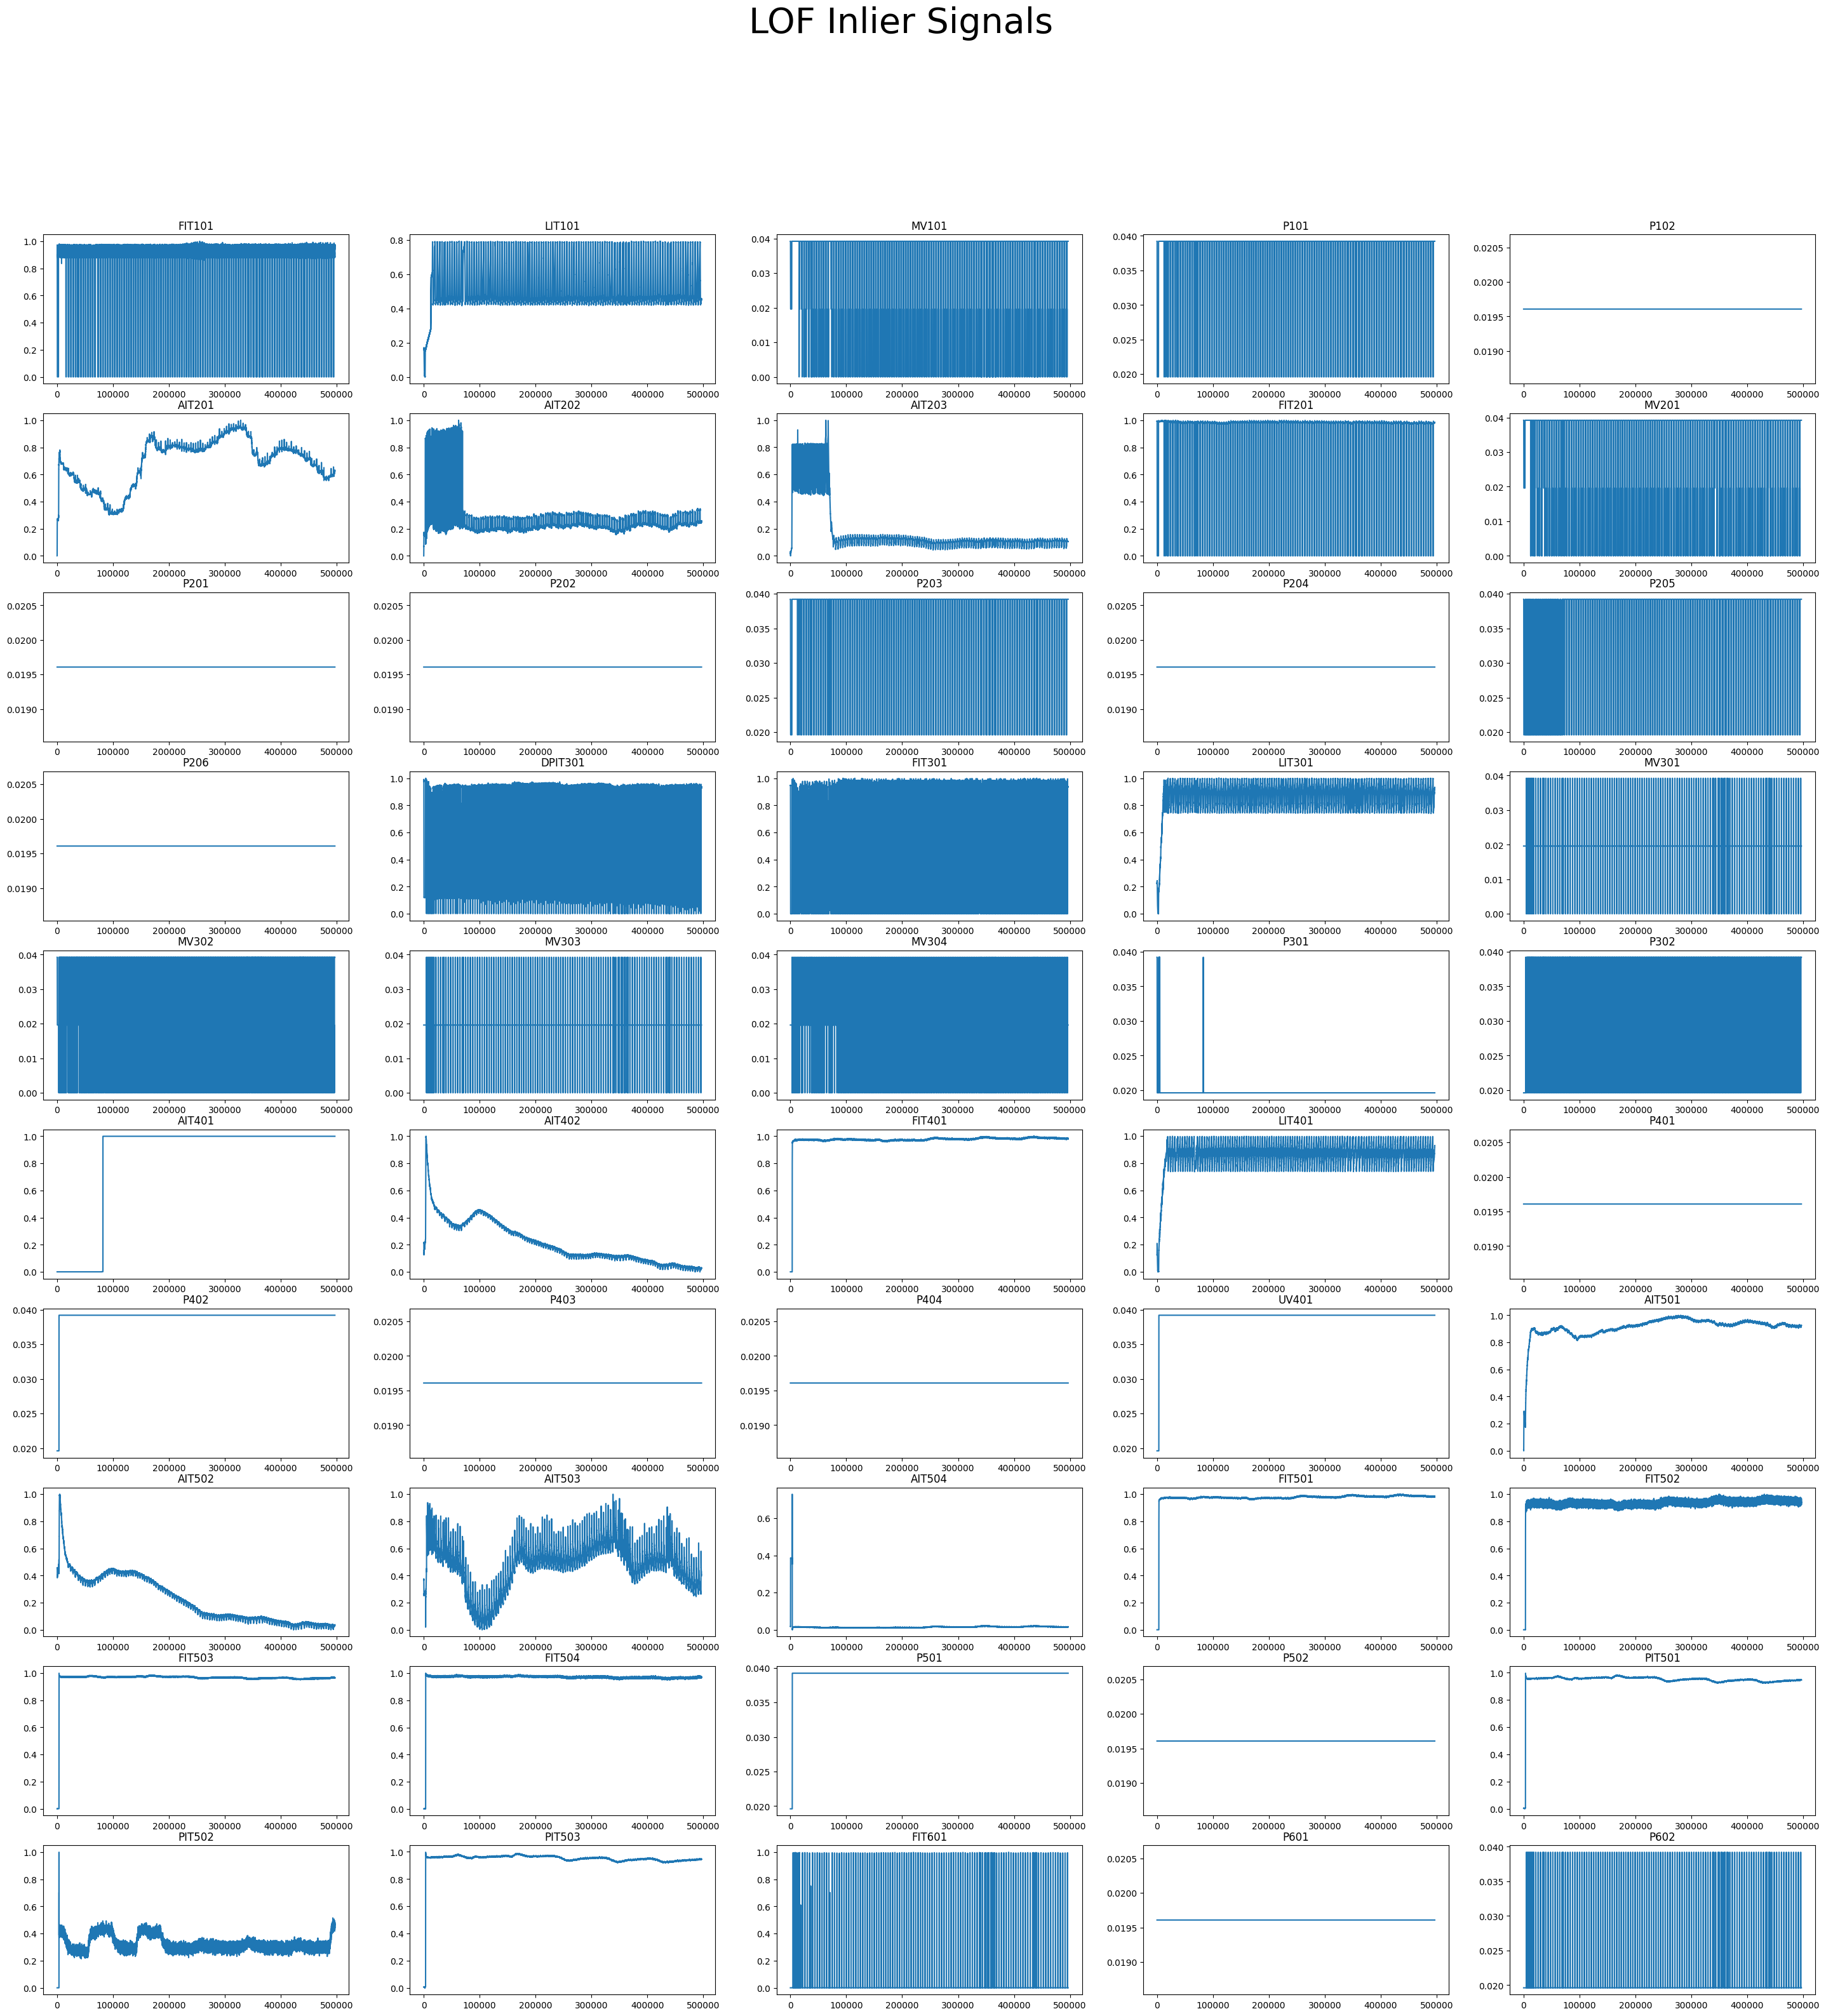

In [47]:
# Plot inliers for the whole period
hor_plots = 5
ver_plots = 10
fig, axs = plt.subplots(ver_plots, hor_plots, figsize=(36, 36))
i, j = 0, 0

for row in range(ver_plots):
    for col in range(hor_plots):
        feature = signals[j]

        axs[row, col].plot(lof_inliers[feature])
        axs[row, col].set_title(feature)
        j = j + 1

# set title 
fig.suptitle('LOF Inlier Signals', fontsize=40)
plt.show()

Here, I computed the LOF scores on the signals for different numbers of neighbors and distance metrics. I chose to continue with **100 neighbors** using the 'elbow' method and choosing the suitable mean LOF score. A lower mean LOF score means that the algorithm is more resistant to noise, makes more balanced estimations and captures better the inherent structure of the data. Regarding metrics, I chose the **Manhattan distance metric**. Even though it has the same mean LOF score as the Euclidean, the LOF scores are overall smaller.

As shown in the end of the plot section, some large abnormalities can be spotted. Their density deviates considerably from the local density of their neighbors. Most of them appear in the beginning of the sequence. Looking at the visualization part, we can see that several signals need some time until achieving a regular behavior, which seems to be the cause for these abnormalities. Moreover, based on timestamp medians, it shows that most outliers appear in the beginning of the sequence, strengthening my theory.

Using LOF in this setting, we can detect **point anomalies**, using the distance of each point from k of its neighbors. However, if we had not removed the sequential aspect of the data, LOF could have also helped us capture contextual anomalies, by comparing points with their previous and next points time-wise.

## 3. PCA task – 1/2 A4 – Individual

### 3a. Plot PCA residuals

In [ ]:
# more preprocessing

# Keep columns for signals
signals = train_data.columns.drop(['Id', 'Timestamp', 'Label'])
print('Number of signals:', len(signals))

# Convert timestamp to datetime
train_data['Timestamp'] = pd.to_datetime(train_data['Timestamp'], dayfirst=True)

# Extract signal data
train_signals = train_data[signals]

# Standardize the data
scaler = StandardScaler()
train_signals_scaled = scaler.fit_transform(train_signals)

train_signals_scaled.shape, np.var(train_signals_scaled, axis=0).shape

In [81]:
# Fit PCA
n_components = 10
pca = PCA(n_components=n_components)
train_signals_pca = pca.fit_transform(train_signals_scaled)

# Reconstruct the original data from the reduced dimensions
train_signals_reconstructed = pca.inverse_transform(train_signals_pca)

(496800, 51)

In [83]:
train_signals_reconstructed[:, 0].shape

(496800,)

In [100]:
# Define the range of components to test
n_components_list = [2, 3, 5, 10, 20, 30]

# Initialize a dictionary to store the residuals for each number of components
residuals_dict = {}

for n_components in n_components_list:
    # Fit PCA
    pca = PCA(n_components=n_components)
    train_signal_pca = pca.fit_transform(train_signals_scaled)
    
    # Reconstruct the original data from the reduced dimensions
    train_signal_reconstructed = pca.inverse_transform(train_signal_pca)
    
    # Compute reconstruction error (residuals) for the 'P101' signal
    residuals = np.mean((train_signals_scaled[:, 0] - train_signal_reconstructed[:, 0]) ** 2)
    # residuals = np.mean((train_signals_scaled - train_signal_reconstructed) ** 2, axis=1)
    residuals_dict[n_components] = residuals


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


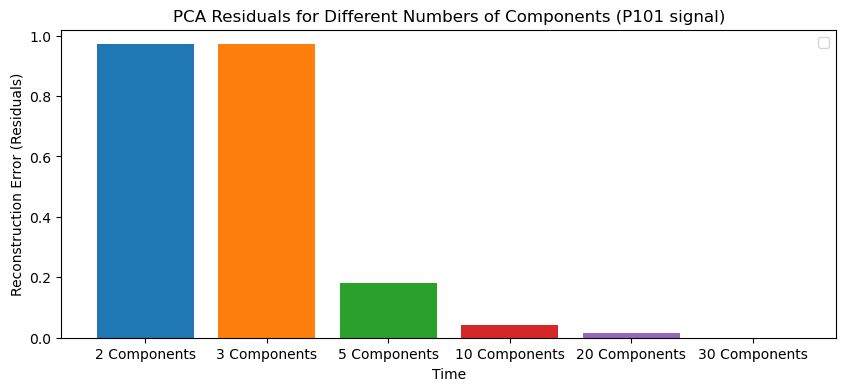

In [101]:
# Plot the residuals for each number of components
plt.figure(figsize=(10, 4))

for n_components, residuals in residuals_dict.items():
    plt.bar(f'{n_components} Components', residuals)

plt.xlabel('Time')
plt.ylabel('Reconstruction Error (Residuals)')
plt.title(f'PCA Residuals for Different Numbers of Components (P101 signal)')
plt.legend()
plt.show()

In [106]:
# Fit PCA
n_components = 30  # You can choose an appropriate number of components
pca = PCA(n_components=n_components)
train_signals_pca = pca.fit_transform(train_signals_scaled)

# Reconstruct the original data from the reduced dimensions
train_signals_reconstructed = pca.inverse_transform(train_signals_pca)

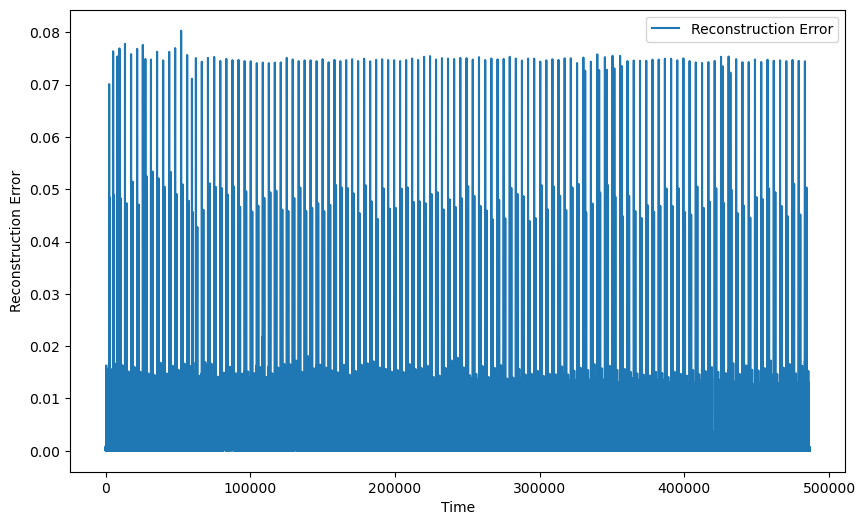

In [107]:
# Compute reconstruction error
# Shed the first 10000 samples which have abnormally high reconstruction error, and make the rest of the data less visible
reconstruction_error = np.mean((train_signals_scaled - train_signals_reconstructed) ** 2, axis=1)[10000:]

# Plot the reconstruction error
plt.figure(figsize=(10, 6))
plt.plot(reconstruction_error, label='Reconstruction Error')
plt.xlabel('Time')
plt.ylabel('Reconstruction Error')
plt.legend()
plt.show()


### 3b. Analysis and answers to the questions

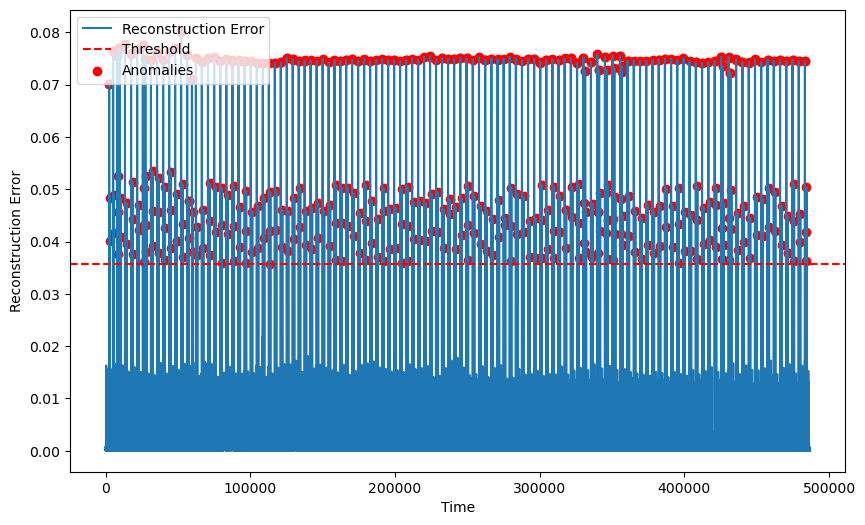

array([False, False, False, False, False, False, False, False, False,
       False])

In [291]:
# Set a threshold for anomaly detection
threshold = np.percentile(reconstruction_error, 99.9)

# Detect anomalies
anomalies = reconstruction_error > threshold

# Plot the anomalies
plt.figure(figsize=(10, 6))
plt.plot(reconstruction_error, label='Reconstruction Error')
plt.axhline(y=threshold, color='r', linestyle='--', label='Threshold')
plt.scatter(np.where(anomalies)[0], reconstruction_error[anomalies], color='red', label='Anomalies')
plt.xlabel('Time')
plt.ylabel('Reconstruction Error')
plt.legend()
plt.show()

### Analysis

We conduct PCA here to detect anomalies using the reconstruction residuals. The chosen reconstruction error function was MSE so that all error values are positive. this makes it easier to visualize the error, as we want all points towards zero.

We did PCA and tested the reconstruction error on the P101 signal for different number of principal components, from 2 to 30. We see a reconstruction error of 1 for 2 and 3 components, with a large steep drop at 5, and slowing down afterwards. Using the elbow method, 5 principal components would be a good choice. We picked 30 as the final count to minimize the residual error and have a manageable amount of abnormalities.

Do we see large abnormalities in the training data? Yes, there is a LOT of abnormalities, almost to the point that the abnormalities appear normal.
Can you explain why these occur? It is hard to say why these abnormalities occur. It could be the simple nature of the data system's water dynamics, that has irregular behaviour every once in a while.

PCA is very good at detecting anomalies that are hidden in a high-dimensional feature space. This is because it tackles outliers in the feature spaces normal to the bases with the highest variances.

## 4. ARMA task – 1/2 A4 - Individual

In [109]:
# Extract the 'AIT402' signal
signal_name = 'AIT402'
train_signal = train_data[[signal_name]]

### 4a. Print relevant plots and/or metrics to determine the parameters.

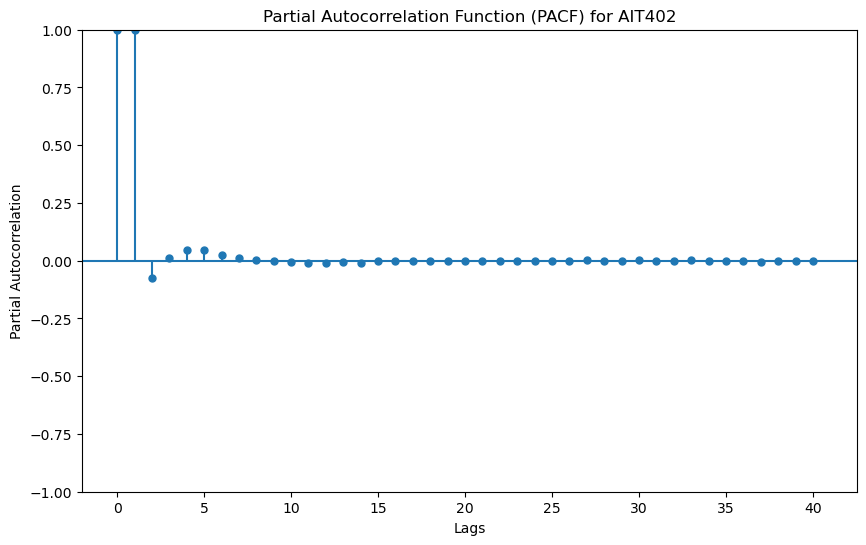

In [113]:
# Plot PACF
fig, ax = plt.subplots(figsize=(10, 6))
sm.graphics.tsa.plot_pacf(train_signal, lags=40, ax=ax)
plt.title(f'Partial Autocorrelation Function (PACF) for {signal_name}')
plt.xlabel('Lags')
plt.ylabel('Partial Autocorrelation')
plt.show()

### 4b. Plots to study the detected anomalies

In [230]:
# Choose the sliding window size based on the PACF plot
# window_size = 3  # Example value

# Prepare the dataset for linear regression
def create_sliding_window(data, window_size):
    X, y = [], []
    for i in range(len(data) - window_size):
        X.append(data[i:i+window_size])
        y.append(data[i+window_size])
    return np.array(X), np.array(y)

# Extract the signal values
signal_values = train_signal.values.flatten()[:200]

signal_values.shape

(200,)

In [257]:
window_sizes = [1, 2, 3, 5, 7]
max_window_size = max(window_sizes)
split_ratio = 0.8
split_index = int(len(signal_values) * split_ratio)

In [258]:
predictions_dict = {}
mse_dict = {}

for window_size in window_sizes:
    # Create sliding windows
    X, y = create_sliding_window(signal_values, window_size)
    
    # Split data into training and test sets
    X_train, X_test = X[:split_index], X[split_index:]
    y_train, y_test = y[:split_index], y[split_index:]
    
    # Train a linear regression model
    model = LinearRegression()
    model.fit(X_train, y_train)
    
    # Predict and store the results
    # y_pred = np.concatenate(np.array([0.0]*window_size), np.array(model.predict(X_test)))
    y_pred = model.predict(X_test)
    mse = mean_squared_error(y_test, y_pred)
    print(f'Window Size: {window_size}, Mean Squared Error: {mse}')
    
    # Store the predictions
    predictions_dict[window_size] = y_pred[max_window_size - window_size:]
    mse_dict[window_size] = mse


Window Size: 1, Mean Squared Error: 0.0005664134716254237
Window Size: 2, Mean Squared Error: 0.000563411494523284
Window Size: 3, Mean Squared Error: 0.0005780126549586236
Window Size: 5, Mean Squared Error: 0.0006186360424327086
Window Size: 7, Mean Squared Error: 0.0004256280140516366


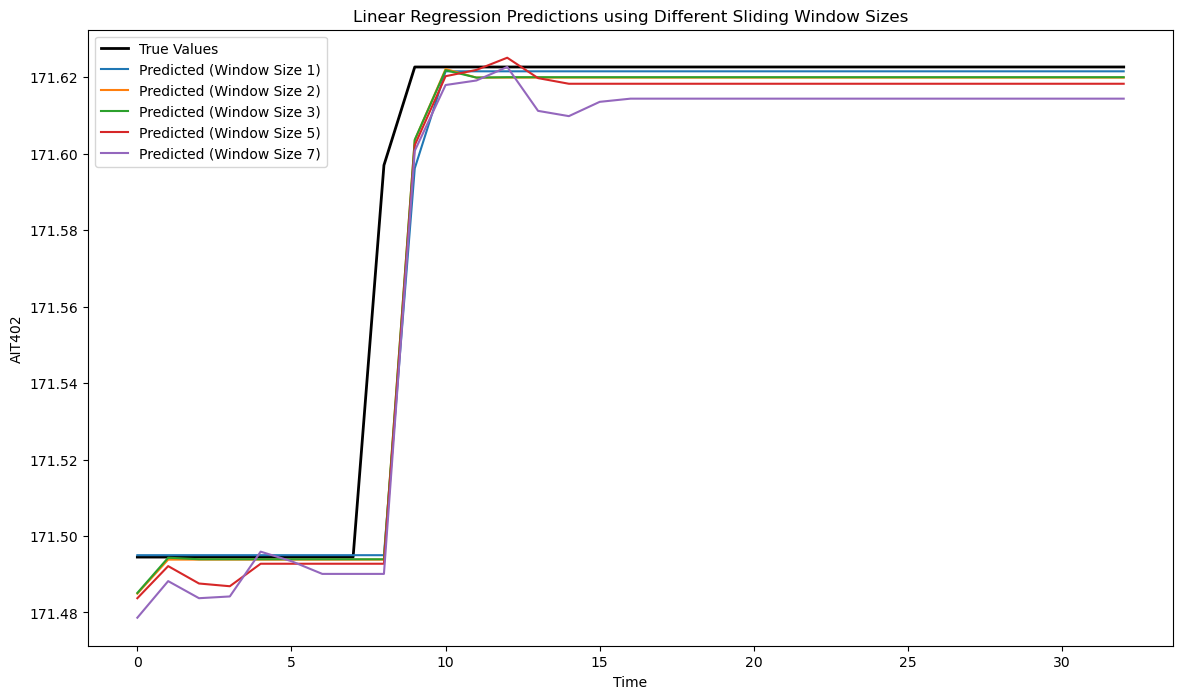

In [259]:
# Plot the results
plt.figure(figsize=(14, 8))

# Plot true values
plt.plot(y_test, label='True Values', color='black', linewidth=2)

# Plot predictions for each window size
for i, window_size in enumerate(window_sizes):
    y_pred = predictions_dict[window_size]
    plt.plot(y_pred, label=f'Predicted (Window Size {window_size})')

plt.title(f'Linear Regression Predictions using Different Sliding Window Sizes')
plt.xlabel('Time')
plt.ylabel(signal_name)
plt.legend()
plt.show()

### Differencing

In [281]:
# Apply differencing to the 'AIT402' signal
train_signal_diff = train_signal.diff().dropna()

# Extract the differenced signal values
signal_values_diff = train_signal_diff.values.flatten()[:200]

In [282]:
split_index_diff = int(len(signal_values_diff) * 0.8)
predictions_dict_diff = {}

for window_size in window_sizes:
    # Create sliding windows for differenced data
    X_diff, y_diff = create_sliding_window(signal_values_diff, window_size)
    
    # Split data into training and test sets
    X_train_diff, X_test_diff = X_diff[:split_index_diff], X_diff[split_index_diff:]
    y_train_diff, y_test_diff = y_diff[:split_index_diff], y_diff[split_index_diff:]
    
    # Train a linear regression model
    model_diff = LinearRegression()
    model_diff.fit(X_train_diff, y_train_diff)
    
    # Predict and store the results
    y_pred_diff = model_diff.predict(X_test_diff)
    mse_diff = mean_squared_error(y_test_diff, y_pred_diff)
    print(f'Differenced Data - Window Size: {window_size}, Mean Squared Error: {mse_diff}')
    
    # Store the predictions
    predictions_dict_diff[window_size] = y_pred_diff[max_window_size - window_size:]

Differenced Data - Window Size: 1, Mean Squared Error: 0.004787593529807049
Differenced Data - Window Size: 2, Mean Squared Error: 0.0047562107826291606
Differenced Data - Window Size: 3, Mean Squared Error: 0.004632343650279959
Differenced Data - Window Size: 5, Mean Squared Error: 0.0046683128049959735
Differenced Data - Window Size: 7, Mean Squared Error: 0.0044860135999322025


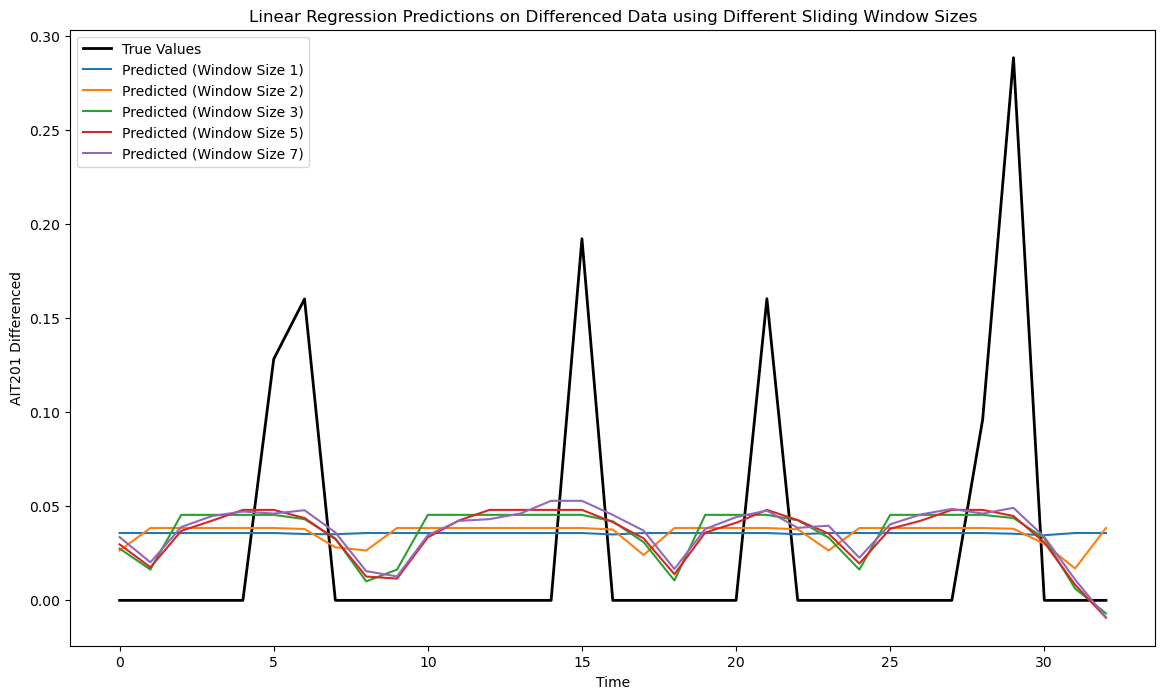

In [283]:
# Plot the results for differenced data
plt.figure(figsize=(14, 8))

# Plot true values
plt.plot(y_test_diff, label='True Values', color='black', linewidth=2)

# Plot predictions for each window size
for i, window_size in enumerate(window_sizes):
    y_pred_diff = predictions_dict_diff[window_size]
    plt.plot(y_pred_diff, label=f'Predicted (Window Size {window_size})')

plt.title(f'Linear Regression Predictions on Differenced Data using Different Sliding Window Sizes')
plt.xlabel('Time')
plt.ylabel(f'{signal_name} Differenced')
plt.legend()
plt.show()

### 4c. Analysis and answers to the questions

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


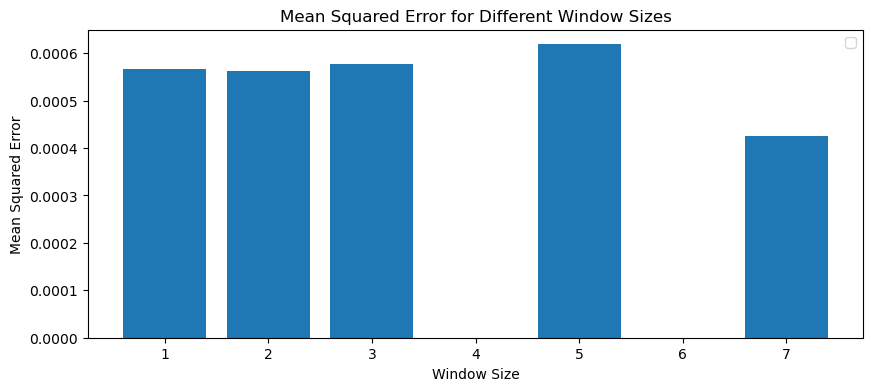

In [260]:
# Plot the residuals for each number of components
plt.figure(figsize=(10, 4))

plt.bar(mse_dict.keys(), mse_dict.values())
plt.title('Mean Squared Error for Different Window Sizes')
plt.xlabel('Window Size')
plt.ylabel('Mean Squared Error')
plt.legend()
plt.show()

### Anomalies in AIT201 Signal

In [276]:
# Extract the 'AIT201' signal
signal_name = 'AIT201'
train_signal = train_data[[signal_name]]


# Extract the signal values
signal_values = train_signal.values.flatten()

# Define the window size
window_size = 5

# Create sliding windows
X, y = create_sliding_window(signal_values, window_size)

# Split data into training and test sets
split_index = int(len(signal_values) * 0.8)
X_train, X_test = X[:split_index], X[split_index:]
y_train, y_test = y[:split_index], y[split_index:]

# Train a linear regression model
model = LinearRegression()
model.fit(X_train, y_train)

# Predict
y_pred = model.predict(X_test)

# Pad the predictions to match the length of the true values
y_pred_padded = np.pad(y_pred, (len(y_test) - len(y_pred), 0), 'constant', constant_values=y_pred[0])

# Calculate residuals
residuals = (y_test - y_pred_padded) ** 2

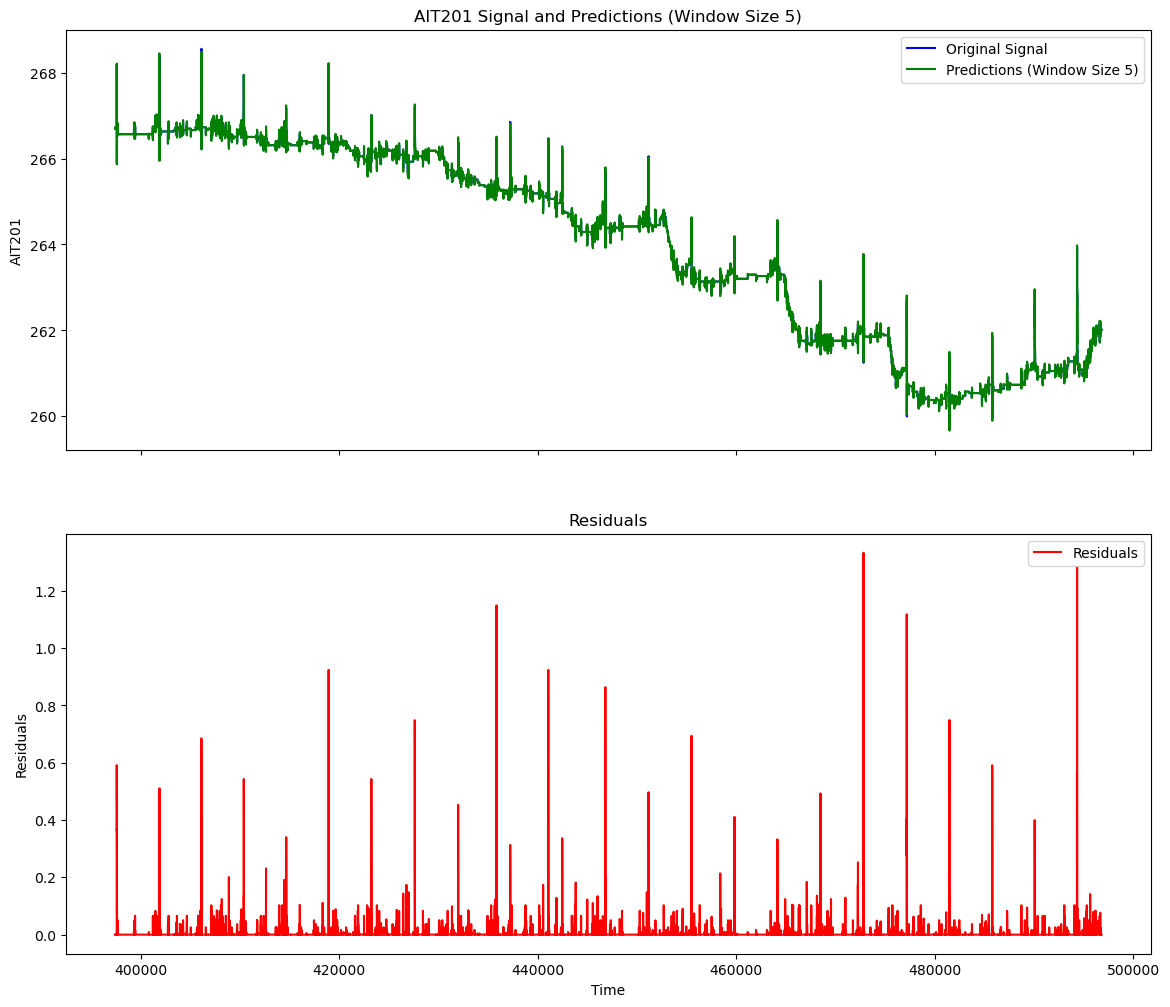

In [277]:
# Plot the results
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(14, 12), sharex=True)

# Plot original signal and predictions on ax1
ax1.plot(range(split_index, len(signal_values)-5), y_test, label='Original Signal', color='blue')
ax1.plot(range(split_index, len(signal_values)-5), y_pred_padded, label='Predictions (Window Size 5)', color='green')
ax1.set_title(f'{signal_name} Signal and Predictions (Window Size 5)')
ax1.set_ylabel(signal_name)
ax1.legend()


# Plot residuals on ax2
ax2.plot(range(split_index, len(signal_values)-5), residuals, label='Residuals', color='red')
ax2.set_title('Residuals')
ax2.set_xlabel('Time')
ax2.set_ylabel('Residuals')
ax2.legend()

plt.show()

In [286]:
# Extract the 'P602' signal
signal_name = 'P602'
train_signal = train_data[[signal_name]]


# Extract the signal values
signal_values = train_signal.values.flatten()

# Define the window size
window_size = 5

# Create sliding windows
X, y = create_sliding_window(signal_values, window_size)

# Split data into training and test sets
split_index = int(len(signal_values) * 0.8)
X_train, X_test = X[:split_index], X[split_index:]
y_train, y_test = y[:split_index], y[split_index:]

# Train a linear regression model
model = LinearRegression()
model.fit(X_train, y_train)

# Predict
y_pred = model.predict(X_test)

# Pad the predictions to match the length of the true values
y_pred_padded = np.pad(y_pred, (len(y_test) - len(y_pred), 0), 'constant', constant_values=y_pred[0])

# Calculate residuals
residuals = (y_test - y_pred_padded) ** 2

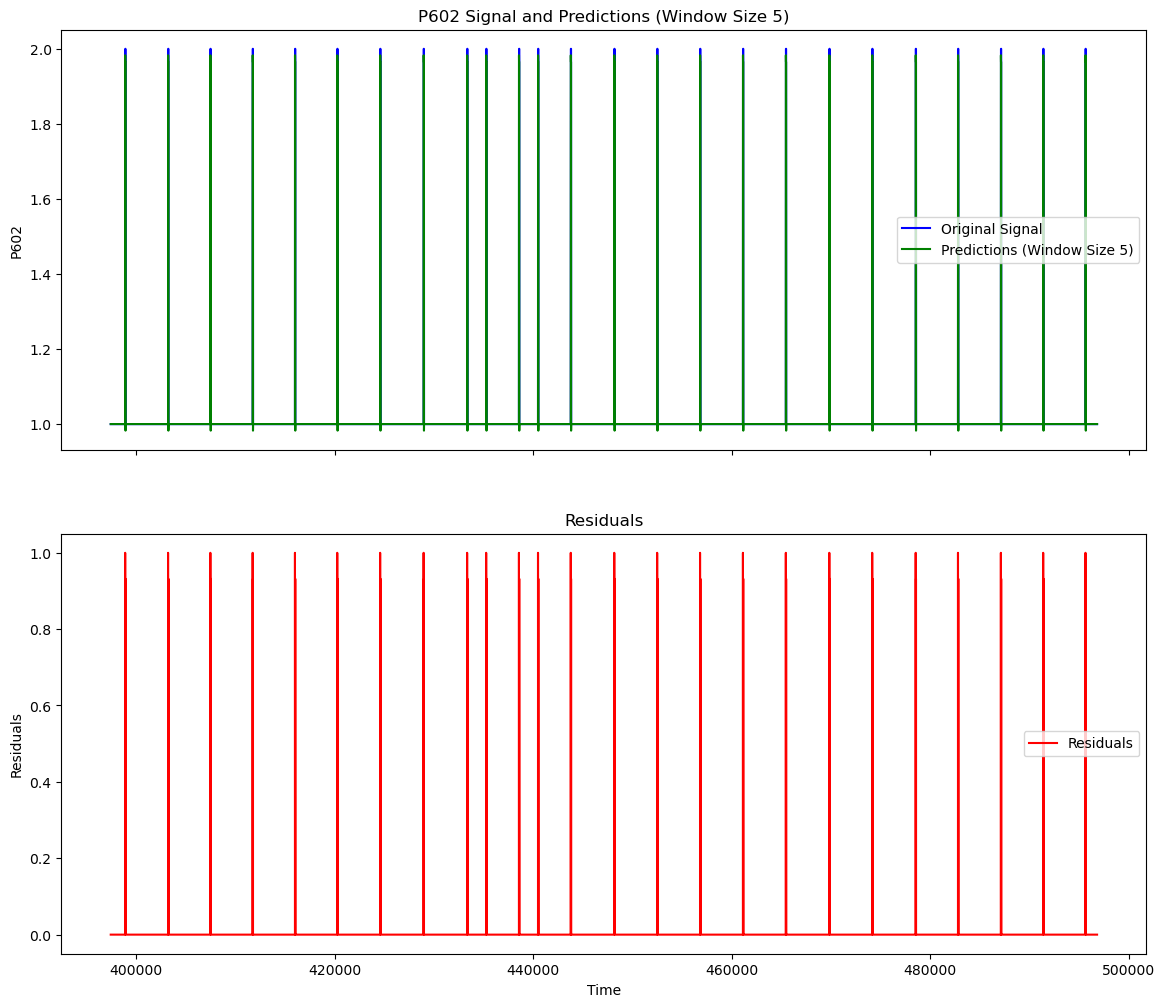

In [287]:
# Plot the results
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(14, 12), sharex=True)

# Plot original signal and predictions on ax1
ax1.plot(range(split_index, len(signal_values)-5), y_test, label='Original Signal', color='blue')
ax1.plot(range(split_index, len(signal_values)-5), y_pred_padded, label='Predictions (Window Size 5)', color='green')
ax1.set_title(f'{signal_name} Signal and Predictions (Window Size 5)')
ax1.set_ylabel(signal_name)
ax1.legend()


# Plot residuals on ax2
ax2.plot(range(split_index, len(signal_values)-5), residuals, label='Residuals', color='red')
ax2.set_title('Residuals')
ax2.set_xlabel('Time')
ax2.set_ylabel('Residuals')
ax2.legend()

plt.show()

In [295]:
# Extract the 'FIT502' signal
signal_name = 'FIT502'
train_signal = train_data[[signal_name]]


# Extract the signal values
signal_values = train_signal.values.flatten()

# Define the window size
window_size = 5

# Create sliding windows
X, y = create_sliding_window(signal_values, window_size)

# Split data into training and test sets
split_index = int(len(signal_values) * 0.8)
X_train, X_test = X[:split_index], X[split_index:]
y_train, y_test = y[:split_index], y[split_index:]

# Train a linear regression model
model = LinearRegression()
model.fit(X_train, y_train)

# Predict
y_pred = model.predict(X_test)

# Pad the predictions to match the length of the true values
y_pred_padded = np.pad(y_pred, (len(y_test) - len(y_pred), 0), 'constant', constant_values=y_pred[0])

# Calculate residuals
residuals = (y_test - y_pred_padded) ** 2

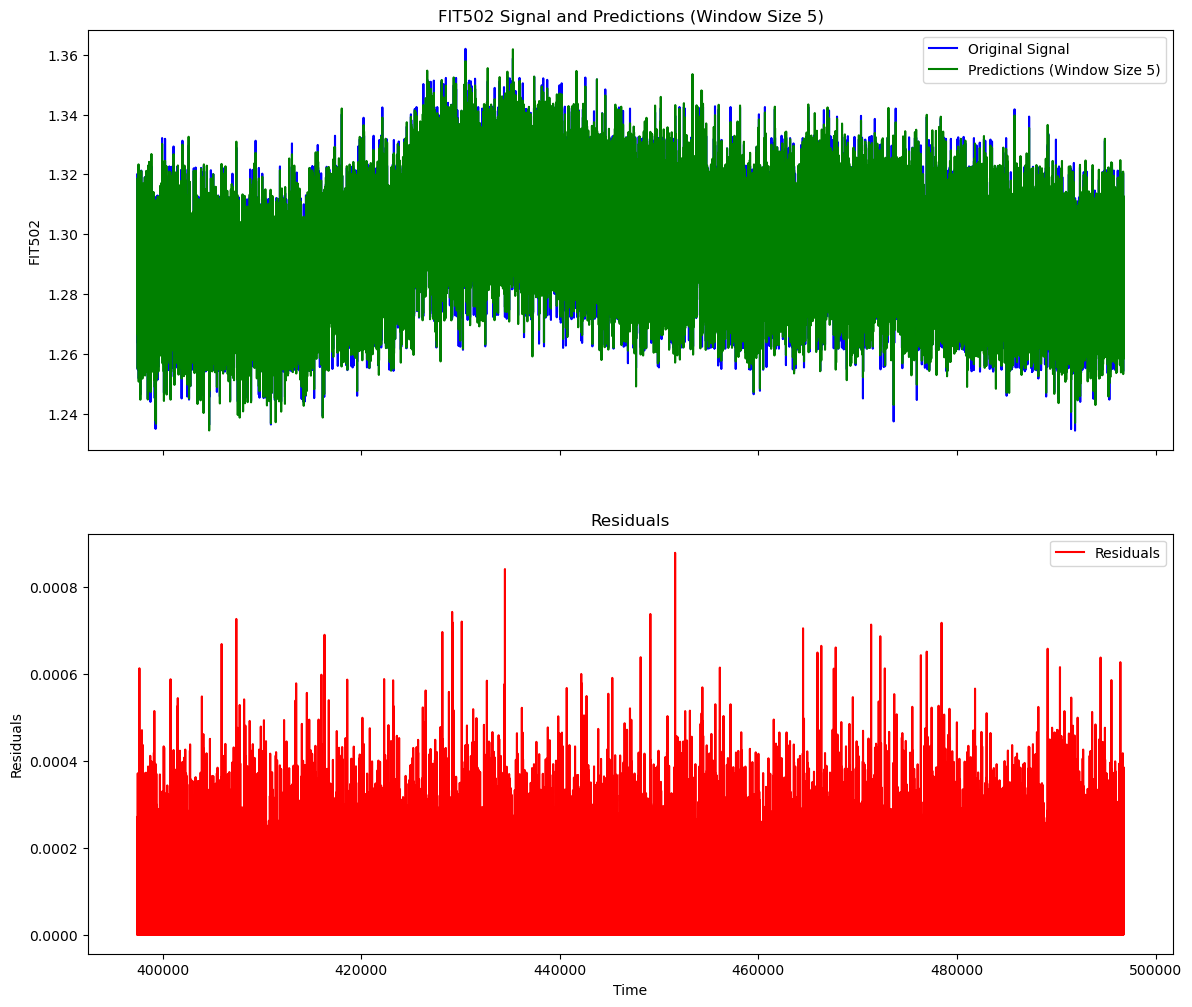

In [296]:
# Plot the results
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(14, 12), sharex=True)

# Plot original signal and predictions on ax1
ax1.plot(range(split_index, len(signal_values)-5), y_test, label='Original Signal', color='blue')
ax1.plot(range(split_index, len(signal_values)-5), y_pred_padded, label='Predictions (Window Size 5)', color='green')
ax1.set_title(f'{signal_name} Signal and Predictions (Window Size 5)')
ax1.set_ylabel(signal_name)
ax1.legend()


# Plot residuals on ax2
ax2.plot(range(split_index, len(signal_values)-5), residuals, label='Residuals', color='red')
ax2.set_title('Residuals')
ax2.set_xlabel('Time')
ax2.set_ylabel('Residuals')
ax2.legend()

plt.show()

The chosen signal to study for the ARMA task was the AIT402 signal. It shows a long-term trend downhill, seeming to be part of a cycle. It also has complex cyclical behavoiur with multiple peaks. We find that ARMA is able to utilize the autocorrelations in the short term and predicts very well the next values, achieving low MSE. It is due to the fact that ARMA detects the cyclic behaviour and learns to model it well.

Next, differencing is applied. It seems that the model then devolves into something decidedly more random. The predictive power seems to slightly decrease, although it is able to detect the peaks pretty well, just missing in the intensity. Removing the long-term trend seems to make it harder for the model to predict, showing it is weaker in short-term features, possibly because those are more noisy.

We study the AIT 201 signal, and predict its future values. We also calculate the squared residuals. We see the residuals are quite random, showing that some abnormalities are being detected. They seem to happen every once in a while, and are very easy to pick out compared to normal values.

We study ARMA on different signals, some with few peaks, and other with a lot. We see it performs very badly on the P602 signal, which is sparse in peaks, but performs better for the FIT502 signal, which is more noisy. Sparsity or low frequencies seems to be its weakness.

## 5. N-gram task – 1/2 A4 - Individual

### Discretization and N-grams

In [39]:
# signal for analysis
ngram_signal = train_data[['AIT201']]

# normalize
scaler = MinMaxScaler()
ngram_signal = scaler.fit_transform(ngram_signal)

# Discretize the signal using percentiles
percentiles = np.percentile(ngram_signal, [10*i for i in range(1, 11)])
discretized_signal = np.digitize(ngram_signal, bins=percentiles, right=True)

# normalize
scaler = MinMaxScaler()
discretized_signal = scaler.fit_transform(discretized_signal)

In [11]:
# Generate N-grams for the discretized signal
def generate_ngrams(sequence, N):
    return [''.join(str(x) for sublist in sequence[i:i+N] for x in sublist) for i in range(len(sequence)-N+1)]

# Calculate N-grams for discretized signal and slicing window length M
def calculate_ngrams(sequence, N, M, step=1):

    windows = [sequence[i:i+M] for i in range(len(sequence)-M+1)]
    # fix for step
    windows = [windows[i] for i in range(len(windows)) if i % step == 0]
    ngram_counts = [Counter(generate_ngrams(window, N)) for window in windows]
    
    # Create a table of N-gram counts for each window
    ngram_keys = list(set(ngram for counts in ngram_counts for ngram in counts.keys()))
    table = pd.DataFrame([{ngram: counts[ngram] for ngram in ngram_keys} for counts in ngram_counts]).fillna(0)
    
    return table

In [13]:
# Create sliding windows of length M and count N-grams
# we are using a step of 100 for faster computation
N = 5
M = 1000
step = 500

table = calculate_ngrams(discretized_signal, N, M, step)

# check table format with N-grams frequencies
ngram_freqs = table.reindex(sorted(table.columns), axis=1)
ngram_freqs.head()

00000  00001  00011  00110  00111  00112  01100  01110  01111  01122  ...  \
0    996      0      0      0      0      0      0      0      0      0  ...   
1    996      0      0      0      0      0      0      0      0      0  ...   
2    996      0      0      0      0      0      0      0      0      0  ...   
3    996      0      0      0      0      0      0      0      0      0  ...   
4    685      1      1      0      0      1      0      0      0      1  ...   

   88999  89988  89998  89999  98888  98889  99888  99988  99998  99999  
0      0      0      0      0      0      0      0      0      0      0  
1      0      0      0      0      0      0      0      0      0      0  
2      0      0      0      0      0      0      0      0      0      0  
3      0      0      0      0      0      0      0      0      0      0  
4      0      0      0      0      0      0      0      0      0      0  

[5 rows x 201 columns]

In [35]:
# function to calculate anomaly scores, based on cosine similarity
def ngram_anomalies(ngram_freqs, neighbors=1):
    # Convert ngram_freqs to a numpy array
    ngram_freqs_np = ngram_freqs.values

    # Fit the NearestNeighbors model
    model = NearestNeighbors(metric='cosine', n_neighbors=neighbors)
    model.fit(ngram_freqs_np)

    # Find the distance and index of the nearest neighbor of each point
    distances, indices = model.kneighbors(ngram_freqs_np)

    # The anomaly score can be defined as the distance to the nearest neighbor
    # print('Distances:', distances.mean(axis=1))
    anomaly_scores = distances.mean(axis=1)
    
    return anomaly_scores

Max anomaly score:  0.0841099189016411


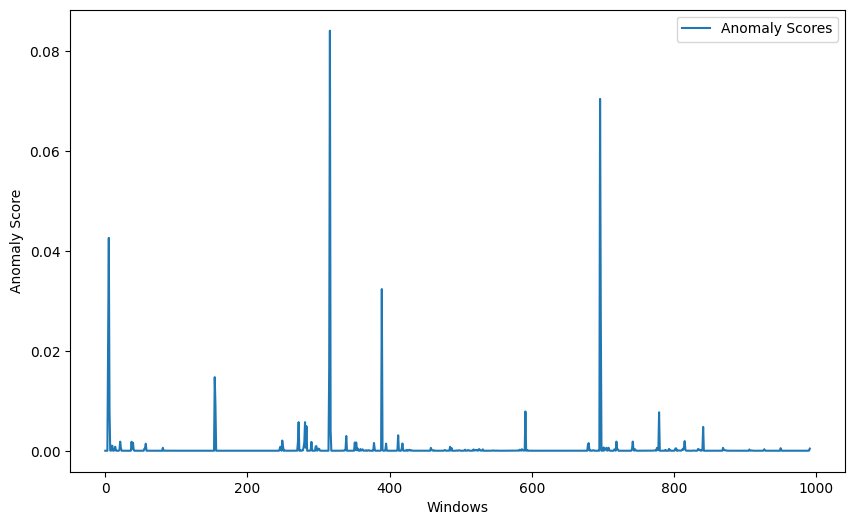

In [36]:
ngram_scores = ngram_anomalies(ngram_freqs, 2)

print("Max anomaly score: ", max(ngram_scores))

# Plot the anomaly scores
plt.figure(figsize=(10, 6))
plt.plot(ngram_scores, label='Anomaly Scores')
plt.xlabel('Windows')
plt.ylabel('Anomaly Score')
plt.legend()
plt.show()

In [40]:
# function for the whole process
def ngram_anomaly_detection(signal, bins=10, N=3, M=1000, step=1, neighbors=1, diff=False):

    # Difference the signal if needed
    if diff:
        signal = signal.diff().fillna(0)

    # Normalize the signal
    scaler = MinMaxScaler()
    signal = scaler.fit_transform(signal)

    # Discretize the signal using percentiles
    percentiles = np.percentile(signal, [(100/bins)*i for i in range(1, bins+1)])
    discretized_signal = np.digitize(signal, bins=percentiles, right=True)

    # Normalize the discretized signal
    scaler = MinMaxScaler()
    discretized_signal = scaler.fit_transform(discretized_signal)
    
    # Calculate N-grams for discretized signal
    table = calculate_ngrams(discretized_signal, N, M, step)
    
    # Calculate anomaly scores
    anomaly_scores = ngram_anomalies(table, neighbors)
    
    if diff:
        return anomaly_scores, table, discretized_signal, signal
    else:
        return anomaly_scores, table, discretized_signal, None

### Differencing

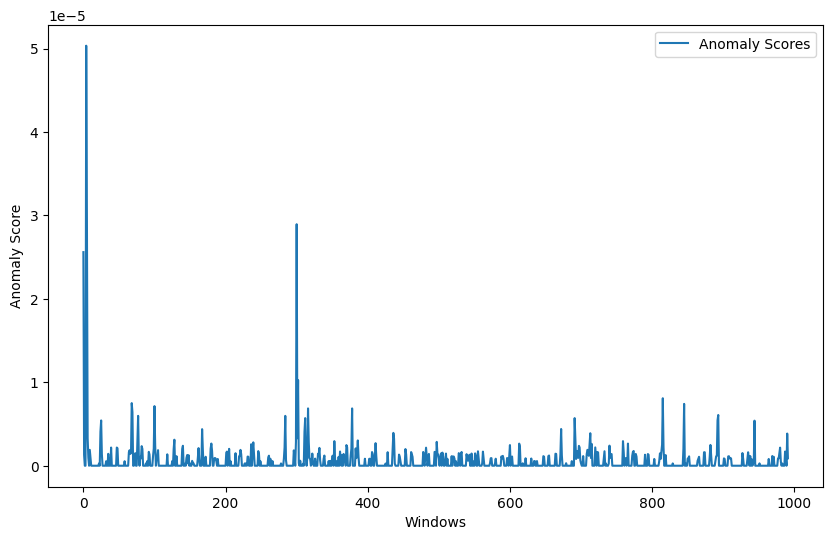

In [41]:
# evaluate ngram anomaly detection with differencing
diff_ngram_scores, diff_ngram_freqs, diff_discretized_signal, diff_ngram_signal = ngram_anomaly_detection(train_data[['AIT201']], bins=10, N=5, M=1000, step=500, neighbors=2, diff=True)

# Plot the anomaly scores
plt.figure(figsize=(10, 6))
plt.plot(diff_ngram_scores, label='Anomaly Scores')
plt.xlabel('Windows')
plt.ylabel('Anomaly Score')
plt.legend()
plt.show()

### 5a. Visualise discretization and residuals

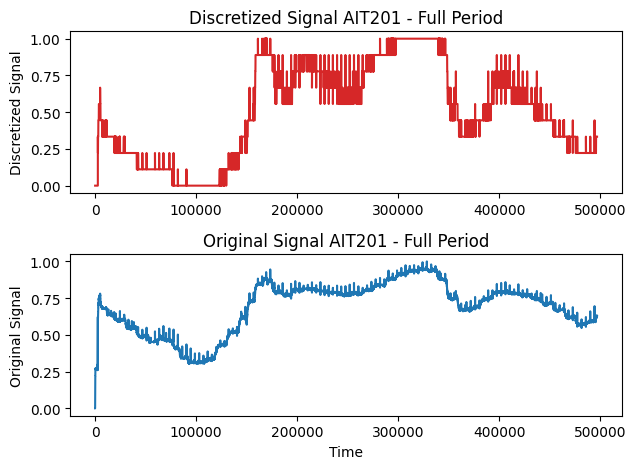

In [42]:
# Plotting signals after scaling with MinMaxScaler
fig, axs = plt.subplots(2)

axs[0].plot(discretized_signal, color='tab:red')
axs[0].set_ylabel('Discretized Signal')
axs[0].set_title('Discretized Signal AIT201 - Full Period')

axs[1].plot(ngram_signal, color='tab:blue')
axs[1].set_xlabel('Time')
axs[1].set_ylabel('Original Signal')
axs[1].set_title('Original Signal AIT201 - Full Period')

fig.tight_layout()
plt.show()

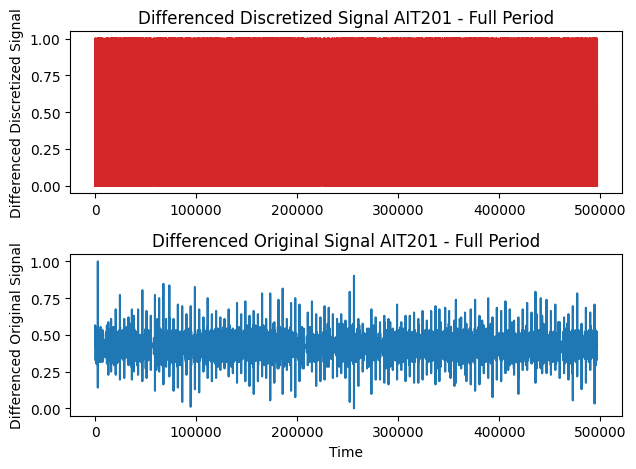

In [44]:
# Plotting signals after scaling with MinMaxScaler
fig, axs = plt.subplots(2)

axs[0].plot(diff_discretized_signal, color='tab:red')
axs[0].set_ylabel('Differenced Discretized Signal')
axs[0].set_title('Differenced Discretized Signal AIT201 - Full Period')

axs[1].plot(diff_ngram_signal, color='tab:blue')
axs[1].set_xlabel('Time')
axs[1].set_ylabel('Differenced Original Signal')
axs[1].set_title('Differenced Original Signal AIT201 - Full Period')

fig.tight_layout()
plt.show()

### 5b. Analysis and answers to the questions. Also provide relevant plots.

#### FIT-501

In [79]:
# Signal 1: FIT501
ngram_fit501 = train_data[['FIT501']]

# N-grams without differencing
fit501_scores, fit501_freqs, fit501_discretized, _ = ngram_anomaly_detection(ngram_fit501, bins=10, N=5, M=1000, step=500, neighbors=2, diff=False)

# N-grams with differencing
diff_fit501_scores, diff_fit501_freqs, diff_fit501_discretized, diff_fit501_signal = ngram_anomaly_detection(ngram_fit501, bins=2, N=2, M=1000, step=500, neighbors=2, diff=True)


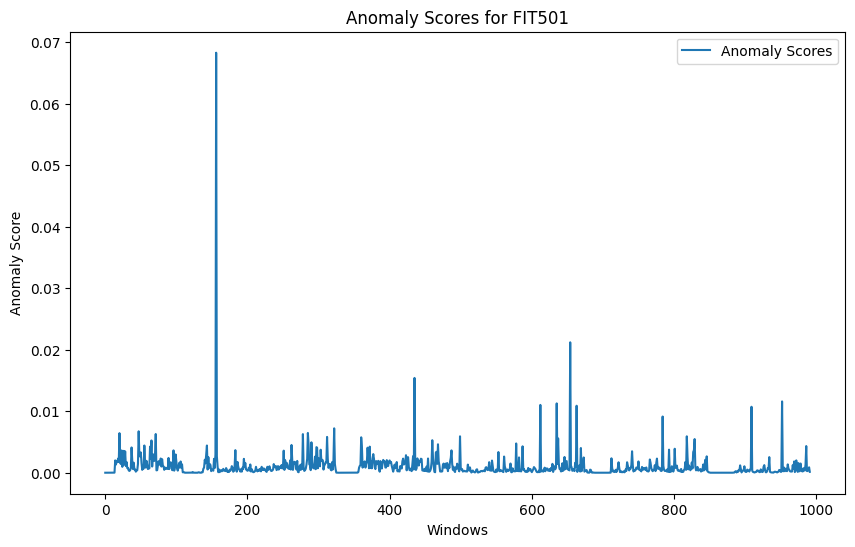

In [80]:
# plot anomaly scores for FIT501
plt.figure(figsize=(10, 6))
plt.plot(fit501_scores, label='Anomaly Scores')
plt.xlabel('Windows')
plt.ylabel('Anomaly Score')
plt.legend()
plt.title('Anomaly Scores for FIT501')
plt.show()

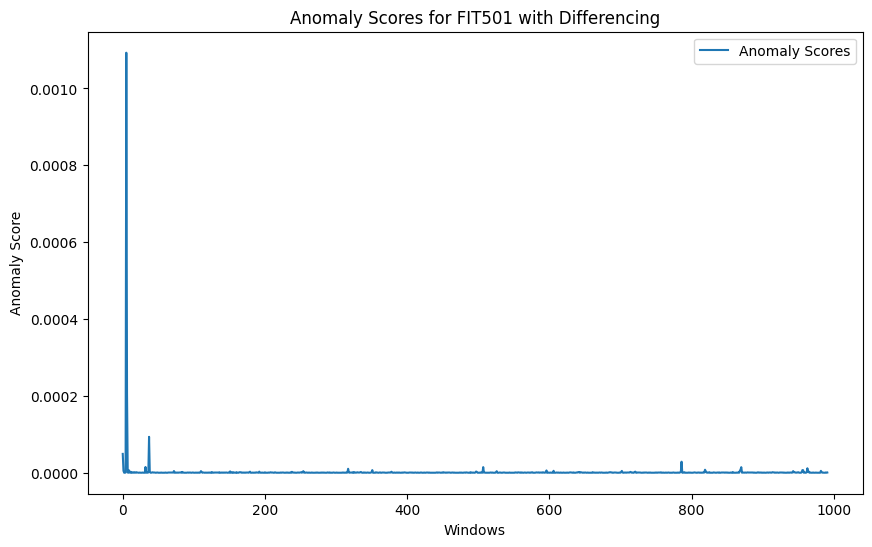

In [81]:
# plot anomaly scores for FIT501 with differencing
plt.figure(figsize=(10, 6))
plt.plot(diff_fit501_scores, label='Anomaly Scores')
plt.xlabel('Windows')
plt.ylabel('Anomaly Score')
plt.legend()
plt.title('Anomaly Scores for FIT501 with Differencing')
plt.show()

#### LIT-301

In [76]:
# Signal 2: LIT301
ngram_lit301 = train_data[['LIT301']]

# N-grams without differencing
lit301_scores, lit301_freqs, lit301_discretized, _ = ngram_anomaly_detection(ngram_lit301, bins=4, N=3, M=1000, step=500, neighbors=2, diff=False)

# N-grams with differencing
diff_lit301_scores, diff_lit301_freqs, diff_lit301_discretized, diff_lit301_signal = ngram_anomaly_detection(ngram_lit301, bins=2, N=2, M=1000, step=500, neighbors=2, diff=True)


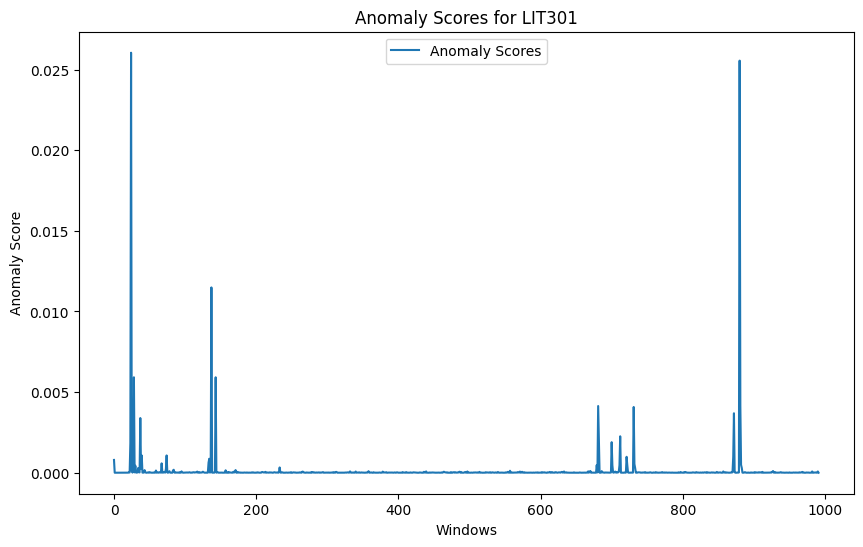

In [77]:
# plot anomaly scores for LIT301
plt.figure(figsize=(10, 6))
plt.plot(lit301_scores, label='Anomaly Scores')
plt.xlabel('Windows')
plt.ylabel('Anomaly Score')
plt.legend()
plt.title('Anomaly Scores for LIT301')
plt.show()

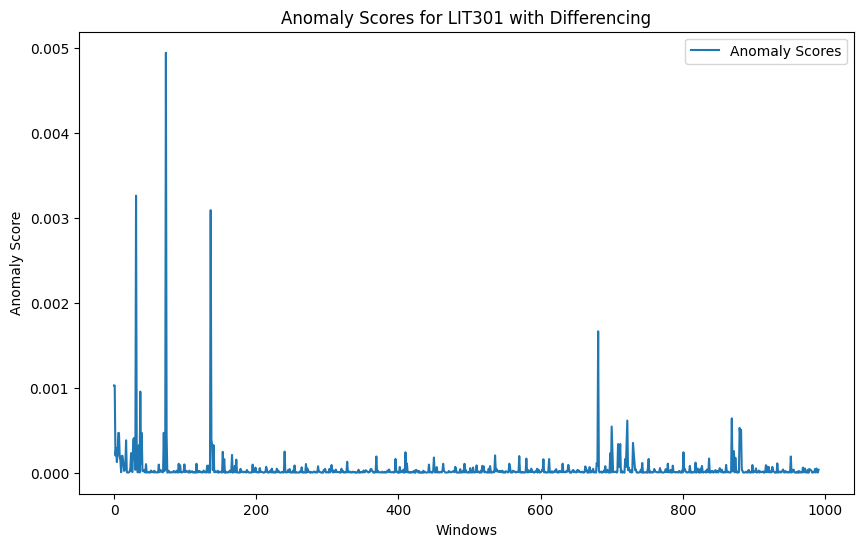

In [78]:
# plot anomaly scores for LIT301 with differencing
plt.figure(figsize=(10, 6))
plt.plot(diff_lit301_scores, label='Anomaly Scores')
plt.xlabel('Windows')
plt.ylabel('Anomaly Score')
plt.legend()
plt.title('Anomaly Scores for LIT301 with Differencing')
plt.show()

#### AIT-502

In [82]:
# Signal 3: AIT502
ngram_ait502 = train_data[['AIT502']]

# N-grams without differencing
ait502_scores, ait502_freqs, ait502_discretized, _ = ngram_anomaly_detection(ngram_ait502, bins=4, N=3, M=1000, step=500, neighbors=2, diff=False)

# N-grams with differencing
diff_ait502_scores, diff_ait502_freqs, diff_ait502_discretized, diff_ait502_signal = ngram_anomaly_detection(ngram_ait502, bins=2, N=2, M=1000, step=500, neighbors=2, diff=True)


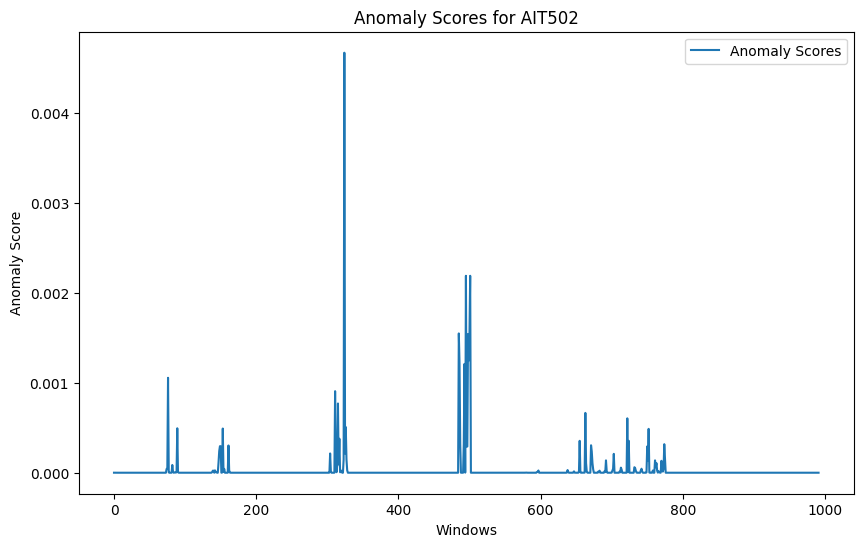

In [83]:
# plot anomaly scores for AIT502
plt.figure(figsize=(10, 6))
plt.plot(ait502_scores, label='Anomaly Scores')
plt.xlabel('Windows')
plt.ylabel('Anomaly Score')
plt.legend()
plt.title('Anomaly Scores for AIT502')
plt.show()

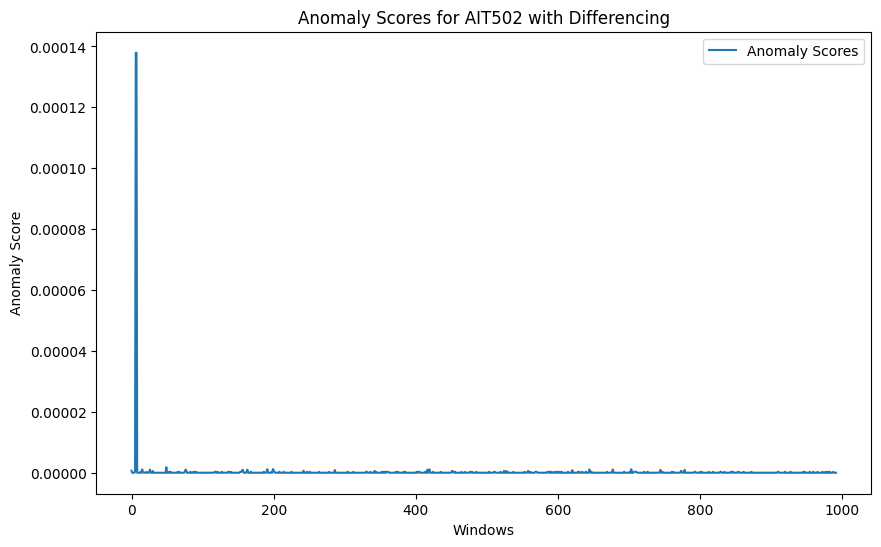

In [84]:
# plot anomaly scores for AIT502 with differencing
plt.figure(figsize=(10, 6))
plt.plot(diff_ait502_scores, label='Anomaly Scores')
plt.xlabel('Windows')
plt.ylabel('Anomaly Score')
plt.legend()
plt.title('Anomaly Scores for AIT502 with Differencing')
plt.show()

**Differencing**: Differencing is an important aspect of this method. It turns the signal stationary, thus making it more robust to noise. As such, it is easier to localize outliers and not get misled by noise within the original signal. However, I should note that it requires extensive fine-tuning with the discretization and n-gram part for effective utilization.

**Anomalies**: The N-gram method helps in detecting contextual anomalies, since it basically compares the n-gram frequencies of a window with those of the adjacent neighbor windows.

**Sensors**: I tested the N-gram method with different sensors above. Because it is translation and scale invariant, it is more effective on sensors with cyclic behavior. It is easier to detect abnormalities in these scenarios, since there is an expected pattern and any deviations would stand out, in terms of n-gram frequencies.

## 6.Comparision task 1 A4 - Individual

### 6a. Use the given guidelines and provide a comparision of the above implemented methods.

In [116]:
# Assuming train_data and val_data are your preprocessed datasets
# train_data and val_data have columns ['Id', 'Timestamp', 'Label', ...other signals...]

# Keep columns for signals
signals = train_data.columns.drop(['Id', 'Timestamp', 'Label'])

# Convert timestamp to datetime
val_data['Timestamp'] = pd.to_datetime(val_data['Timestamp'], dayfirst=True)

# Extract signal data
train_signals = train_data[signals]
val_signals = val_data[signals]

# Extract labels
val_labels = val_data['Label'].values

#### LOF

In [206]:
# We will use LOF inliers from end of LOF section
# to model the normal behavior of the system

# sensors and actuators are defined in visualization part
lof_train_sensors = lof_inliers[sensors]
lof_train_actuators = lof_inliers[actuators]

lof_val_sensors = val_signals[sensors]
lof_val_actuators = val_signals[actuators]

# use MinMaxScaler on sensors
scaler = MinMaxScaler()
scaled_sensors = scaler.fit_transform(train_data[sensors])
# lof_train_sensors = pd.DataFrame(scaled_sensors, columns=lof_train_sensors.columns, index=lof_train_sensors.index)
scaled_sensors2 = scaler.transform(lof_val_sensors)
lof_val_sensors = pd.DataFrame(scaled_sensors2, columns=lof_val_sensors.columns, index=lof_val_sensors.index)

# manually scale actuators
# we divide them by the total number of signals to regulate
# their impact on distance metrics
# lof_train_actuators = lof_train_actuators / len(signals)
lof_val_actuators = lof_val_actuators / len(signals)

# combine sensors and actuators
lof_train_data = pd.concat([lof_train_sensors, lof_train_actuators], axis=1)
lof_val_data = pd.concat([lof_val_sensors, lof_val_actuators], axis=1)
# lof_train_data = lof_train_sensors
# lof_val_data = lof_val_sensors

In [211]:
# NOTE: this cell is computationally expensive - takes around 30 minutes
# choose a smaller number of neighbors or the euclidean distance metric to reduce computation time

n = 100
method = "manhattan"

# storing LOF scores for later usage
lof_comparison_dict = {}
lof_comparison_labels = {}

# Apply LOF
lof = LocalOutlierFactor(n_neighbors=n, metric=method, novelty=True)
lof.fit(lof_train_data)
y_pred = lof.predict(lof_val_data)
lof_comparison_labels[n] = y_pred

lof_scores = -lof.negative_outlier_factor_
lof_comparison_dict[n] = lof_scores

print("LOF scores for n =", n, " and method =", method, " are computed.")


LOF scores for n = 100  and method = euclidean  are computed.


In [208]:
# NOTE: cell to store LOF scores in .json files
# no need to run this cell if you do not want to store LOF scores
# to store LOF scores in .json files, uncomment code below

# # make directory for lof files
# if not os.path.exists('lof_files'):
#     os.makedirs('lof_files')

# # store LOF scores in .json files
# for key in lof_comparison_dict.keys():
#     with open('lof_files/lof_final_scores_' + str(key) + '.json', 'w') as f:
#         json.dump(lof_comparison_dict[key].tolist(), f)

# # store LOF labels in .json files
# for key in lof_comparison_labels.keys():
#     with open('lof_files/lof_final_labels_' + str(key) + '.json', 'w') as f:
#         json.dump(lof_comparison_labels[key].tolist(), f)

In [192]:
# NOTE: code to load precomputed LOF scores and labels
# uncomment the following code to load LOF scores and labels

# # load LOF scores from .json files
# lof_comparison_dict = {}
# with open('lof_files/lof_final_scores_' + str(100) + '.json', 'r') as f:
#     lof_comparison_dict[100] = json.load(f)

# # load LOF labels from .json files
# lof_comparison_labels = {}
# with open('lof_files/lof_final_labels_' + str(100) + '.json', 'r') as f:
#     lof_comparison_labels[100] = json.load(f)


In [212]:
# format labels for comparison
for i in lof_comparison_labels.keys():
    lof_comparison_labels[i] = [1 if label == -1 else 0 for label in lof_comparison_labels[i]]

In [213]:
# performance evalutaion

_, fp, _, tp = confusion_matrix(val_labels, lof_comparison_labels[100]).ravel()

# Performance Metrics
print(f'True Positives: {tp}')
print(f'False Positives: {fp}')
print(f'F1: {f1_score(val_labels, lof_comparison_labels[100])}')
print(f'Precision: {precision_score(val_labels, lof_comparison_labels[100])}')
print(f'Recall: {recall_score(val_labels, lof_comparison_labels[100])}')
print(f'Accuracy: {accuracy_score(val_labels, lof_comparison_labels[100])}')


True Positives: 792
False Positives: 5899
F1: 0.08935522084955153
Precision: 0.11836795695710656
Recall: 0.07176513229430953
Accuracy: 0.9282402571135184


#### PCA

thresholds: [1.59239891e-02 1.59432844e-02 1.63252731e-02 ... 2.69429811e+01
 2.69534779e+01 2.69817377e+01]
thresholds shape: (220860,)
thresholds: [1.01555322e-02 1.01715019e-02 1.02845954e-02 ... 1.33776842e+01
 1.33810175e+01 1.33820297e+01]
thresholds shape: (220860,)
thresholds: [3.96176096e-04 4.01117046e-04 4.05759525e-04 ... 1.29749374e+01
 1.29752299e+01 1.29753418e+01]
thresholds shape: (220860,)
thresholds: [9.64135778e-05 1.13126878e-04 1.18977666e-04 ... 3.04139298e+00
 3.15334875e+00 3.30967533e+00]
thresholds shape: (220860,)


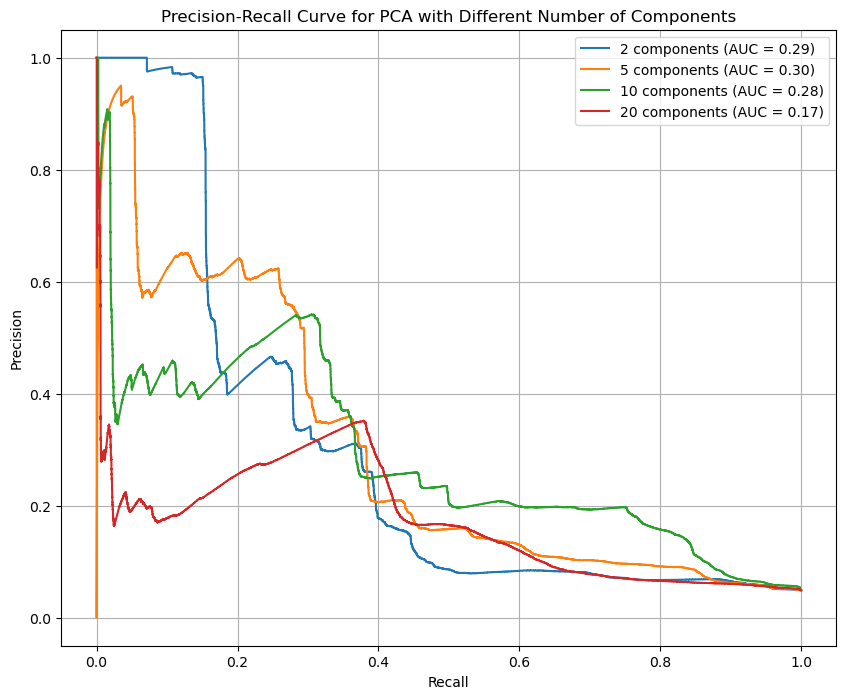

In [309]:
# Standardize the data
scaler = StandardScaler()
train_signals_scaled = scaler.fit_transform(train_signals)
val_signals_scaled = scaler.transform(val_signals)

# Function to calculate reconstruction error
def calculate_reconstruction_error(pca, data_scaled):
    data_pca = pca.transform(data_scaled)
    data_reconstructed = pca.inverse_transform(data_pca)
    reconstruction_error = np.mean((data_scaled - data_reconstructed) ** 2, axis=1)
    return reconstruction_error

# Define the range of components to test
n_components_list = [2, 5, 10, 20]

# Initialize a dictionary to store precision-recall data
pr_data = {}

for n_components in n_components_list:
    # Fit PCA on the training data
    pca = PCA(n_components=n_components)
    pca.fit(val_signals_scaled)
    
    # Calculate reconstruction error for the validation set
    reconstruction_error = calculate_reconstruction_error(pca, val_signals_scaled)
    
    # Calculate precision, recall, and thresholds
    precision, recall, thresholds = precision_recall_curve(val_labels, reconstruction_error)
    print('thresholds:', thresholds)
    print('thresholds shape:', thresholds.shape)
    pr_data[n_components] = (precision, recall, thresholds, auc(recall, precision))

# # Plot the precision-recall curves
# plt.figure(figsize=(10, 8))

# for n_components, (precision, recall, thresholds, pr_auc) in pr_data.items():
#     plt.plot(recall, precision, label=f'{n_components} components (AUC = {pr_auc:.2f})')

# plt.xlabel('Recall')
# plt.ylabel('Precision')
# plt.title('Precision-Recall Curve for PCA with Different Number of Components')
# plt.legend()
# plt.grid(True)
# plt.show()


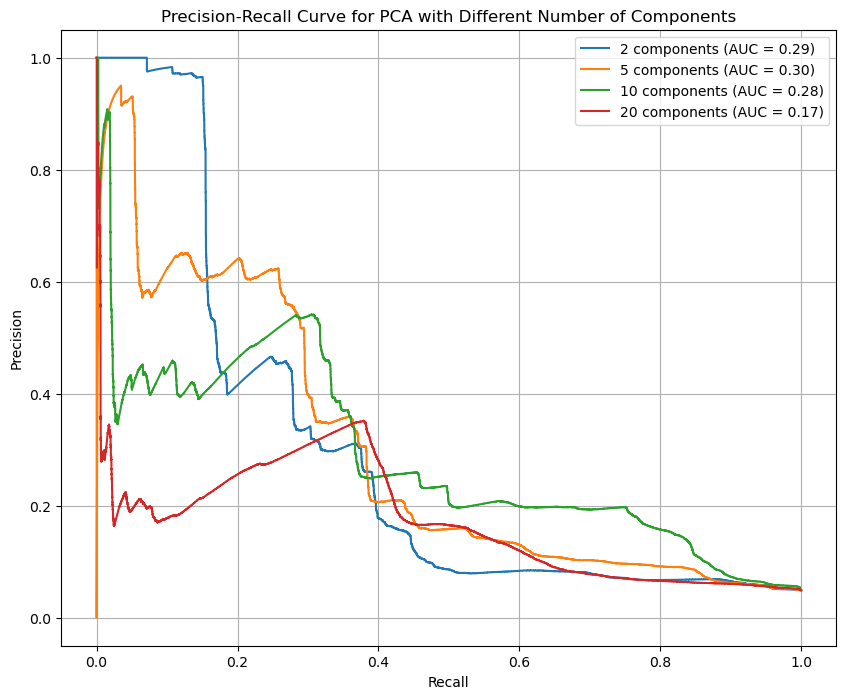

Optimal threshold for 2 components: 1.5647, F1 Score: 0.3405
Optimal threshold for 5 components: 1.0776, F1 Score: 0.3750
Optimal threshold for 10 components: 0.3374, F1 Score: 0.3950
Optimal threshold for 20 components: 0.0194, F1 Score: 0.3648


In [310]:
# Find the threshold that maximizes the F1 score for each number of components
optimal_thresholds = {}

for n_components, (precision, recall, thresholds, pr_auc) in pr_data.items():
    f1_scores = 2 * (precision * recall) / (precision + recall + 1e-10)  # Adding a small value to avoid division by zero
    optimal_idx = np.argmax(f1_scores)
    optimal_threshold = thresholds[optimal_idx]
    optimal_f1_score = f1_scores[optimal_idx]
    optimal_thresholds[n_components] = (optimal_threshold, optimal_f1_score)

# Plot the precision-recall curves
plt.figure(figsize=(10, 8))

for n_components, (precision, recall, thresholds, pr_auc) in pr_data.items():
    plt.plot(recall, precision, label=f'{n_components} components (AUC = {pr_auc:.2f})')

plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve for PCA with Different Number of Components')
plt.legend()
plt.grid(True)
plt.show()

# Print the optimal thresholds and corresponding F1 scores
for n_components, (optimal_threshold, optimal_f1_score) in optimal_thresholds.items():
    print(f'Optimal threshold for {n_components} components: {optimal_threshold:.4f}, F1 Score: {optimal_f1_score:.4f}')

#### N-Grams

In [233]:
# hyperparameters for multivariate
ngram_length = 4 
discretization_levels = 10
window_length = 1000
window_overlap = 500
threshold = 99.7

# function to calculate anomaly scores, for multivariate data
def multivariate_ngram_anomalies(val_data, n, bins, w_len, w_overlap, threshold, neighbors):

    anomalies_indexes = []

    for s in signals:
        # train ngram anomaly detection
        diff_ngram_scores, diff_ngram_freqs, diff_discretized_signal, diff_ngram_signal = ngram_anomaly_detection(val_data[[s]], bins=bins, N=n, M=w_len, step=w_overlap, neighbors=neighbors, diff=True)

        # find indexes of diff_ngram_scores above the threshold percentile
        anomalies = np.where(diff_ngram_scores > np.percentile(diff_ngram_scores, threshold))
        anomalies_indexes.append(anomalies)

    return anomalies_indexes

In [234]:
# find anomalies from n-grams
anomalies_indexes = multivariate_ngram_anomalies(val_data, ngram_length, discretization_levels, window_length, window_overlap, threshold, 2)


In [236]:
# keep unique indexes from arrays within list
# Flatten each array in anomalies_indexes and concatenate
anomalies_indexes_flat = np.concatenate([arr[0].flatten() for arr in anomalies_indexes])

# Get unique values
unique_anomalies = np.unique(anomalies_indexes_flat)

# translate from windows to points
indexes_of_anomalies = []

for a in unique_anomalies:
    new_idxs = [i for i in range(a*window_overlap, a*window_overlap + window_length)]
    indexes_of_anomalies += new_idxs

indexes_of_anomalies = np.unique(indexes_of_anomalies)

# create list of anomaly labels
anomaly_labels = [1 if i in indexes_of_anomalies else 0 for i in range(len(val_data))]

# performance evalutaion
_, fp, _, tp = confusion_matrix(val_labels, anomaly_labels).ravel()

# Performance Metrics
print(f'True Positives: {tp}')
print(f'False Positives: {fp}')
print(f'F1: {f1_score(val_labels, anomaly_labels)}')
print(f'Precision: {precision_score(val_labels, anomaly_labels)}')
print(f'Recall: {recall_score(val_labels, anomaly_labels)}')
print(f'Accuracy: {accuracy_score(val_labels, anomaly_labels)}')


True Positives: 3092
False Positives: 31908
F1: 0.13432965505256755
Precision: 0.08834285714285714
Recall: 0.28017397607828926
Accuracy: 0.8228477189176694


#### Explanations

**Method**: We are using F1-Score, which is a combination of precision and recall. The classes between anomalous and normal points are unbalanced. It would be very expensive and uninformative for a model to predict all anomalies, but also give a lot of false negatives, as the analyst won't be able to study everything predicted. 

**LOF**: The F1-Score (0.089) with LOF is not sufficient. The reason is that, because of the size of the train data, we could not perform extensive hyper-parameter tuning to find the optimal neighbors and the optimal metric. Also, a more careful feature engineering could help us model the signals to detect anomalies more precisely.

**PCA**: Best F1-Score (0.395) was found with with 10 components. We could further explore the number of components to find the true optimal number to achieve the best F1-Score, however the available time did not allow us to perform extensive analysis.

**N-Gram**: The F1-Score (0.134) with N-Grams is not optimal. Although it is expected, since there are a lot of parameters that require fine-tuning and we did not have the time to explore them.

## Kaggle

In [298]:
# Define the anomaly detection function
def detect_anomalies(residuals, threshold):
    labels = (np.abs(residuals) > threshold).astype(int)
    return labels

# Set a threshold for anomaly detection
threshold = np.percentile(reconstruction_error, 99)

# print(anomaly_df)

# # Plot the results
# fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(14, 12), sharex=True)

# # Plot original signal and predictions on ax1
# ax1.plot(range(len(signal_values)), signal_values, label='Original Signal', color='blue')
# ax1.plot(range(split_index, len(signal_values)), y_pred_padded, label='Predictions (Window Size 5)', color='green')
# ax1.set_title(f'{signal_name} Signal and Predictions (Window Size 5)')
# ax1.set_ylabel(signal_name)
# ax1.legend()

# # Plot residuals on ax2
# ax2.plot(range(split_index, len(signal_values)), residuals, label='Residuals', color='red')
# ax2.scatter(anomaly_df['ID'], residuals[anomaly_labels == 1], color='red', marker='x', label='Anomalies')
# ax2.set_title('Residuals and Anomalies')
# ax2.set_xlabel('Time')
# ax2.set_ylabel('Residuals')
# ax2.legend()

# plt.show()

In [312]:
# more preprocessing

# Keep columns for signals
signals = test_data.columns.drop(['Id', 'Timestamp'])
print('Number of signals:', len(signals))


# Extract signal data
train_signals = train_data[signals]
test_signals = test_data[signals]

# Standardize the data
scaler = StandardScaler()
train_signals_scaled = scaler.fit_transform(train_signals)
test_signals_scaled = scaler.transform(test_signals)

# Standardize the data
scaler = StandardScaler()
test_signals_scaled = scaler.fit_transform(test_signals)

test_signals_scaled.shape, np.var(test_signals_scaled, axis=0).shape

Number of signals: 51


((224960, 51), (51,))

In [335]:
# Fit PCA
n_components = 10
pca = PCA(n_components=n_components)
test_signals_pca = pca.fit_transform(test_signals_scaled)

# Reconstruct the original data from the reduced dimensions
test_signals_reconstructed = pca.inverse_transform(test_signals_pca)

residuals = np.mean((test_signals_scaled - test_signals_reconstructed) ** 2, axis=1)

# Set a threshold for anomaly detection
threshold = np.percentile(residuals, 98)

# # Determined using the validation set
# threshold = 0.3374

anomaly_labels = detect_anomalies(residuals, threshold)

# Create a DataFrame with columns 'ID' and 'label'
anomaly_df = pd.DataFrame({
    'Id': np.arange(224959, len(residuals)+224959),
    'label': anomaly_labels
})

anomaly_df.head()

Id  label
0  224959      0
1  224960      0
2  224961      0
3  224962      0
4  224963      0

In [336]:
# Write the DataFrame to a CSV file
anomaly_df.to_csv('anomalies.csv', index=False)